# Sleep Prediction
Here we try to use environmental parameters in addition to mood and activity characteristics to see if we are able to predict sleep quality.

## Features
In this analysis, we are going to consider the following features:
1. **Acitivity**: The main metrics for activity that we will use are:
    * Daily Steps
    * Intensity Levels
2. **Mood**: We have five metrics for mood:
    * Content
    * Lonely
    * Sadness
    * Stress
    * Energy Level 
3. **IEQ**: There are many measurements of IEQ that we consider:
    * CO$_2$
    * CO
    * PM$_{2.5}$
    * NO$_2$
    * TVOCs
    * Temperature
    * Relative Humidity
    
## Targets
The targets will be all metrics related to sleep quality:
1. **Self-Report**: There are four metrics for self-report sleep quality reported via EMA:
    * TST
    * SOL
    * NAW
    * Restfulness
2. **Fitbit-Measured**: There are also four metrics of sleep quality that we can use from Fitbit:
    * TST
    * SE
    * REM Percentage
    * Light Percentage
    * Deep Percentage

In [9]:
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
# general
import os
import sys
sys.path.append('../')
# user-defined functions
from src.visualization import visualize
# basic data science
import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np
# timeseries
from datetime import datetime, timedelta
# plottings
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns
import matplotlib.dates as mdates

# Table of Contents
1. [Data Import](#data-import)
3. [Target Encoding](#encoding)
4. [Feature Engineering](#feature_engineering)
5. [Prediction](#prediction)
    1. [Fitbit Sleep Targets](#fitbit-sleep-prediction)
        1. TST
        2. SOL
        3. WASO
        4. REM:nREM
        5. SE
    2. [Self-Report Sleep Targets](#self-report-sleep-prediction)
        1. TST
        2. SOL
        3. NAW
        4. Restfulness
6. [Prediction with Encoded Features](#prediction_encoded)
7. [Final Analysis](#final_analysis)

<a id="data-import"></a>

# Data Import
For this analysis we want to only consider nights when we have _all_ the available data. These are also the nights that we have confirmed participants are home according to GPS traces. 

## Feature: IEQ
We start with IEQ data beacuse from previous analysis, this dataset has already been curated to include the relevant nights. However, there are quite a few columns that are not necessary for this analysis that have to be removed.

In [11]:
ieq_raw = pd.read_csv("../data/processed/beacon_by_night-ux_s20.csv",parse_dates=["start_time","end_time",],infer_datetime_format=True)
ieq_raw = ieq_raw[(ieq_raw["home"] == 1) | (ieq_raw["increasing_co2"] > 0.5)]
ieq_raw.drop(["home","increasing_co2","ema","pm1_number","pm2p5_number","pm10_number","pm1_mass","pm10_mass","no2"],axis="columns",inplace=True)
ieq_raw = ieq_raw.groupby(["beacon","beiwe","redcap","start_time","end_time"]).median()
ieq_raw = ieq_raw.add_suffix("_median")
ieq_raw.reset_index(inplace=True)
ieq = ieq_raw.copy()
ieq.head()

,beacon,beiwe,redcap,start_time,end_time,tvoc_median,lux_median,co_median,co2_median,pm2p5_mass_median,temperature_c_median,rh_median
0,1,kyj367pi,10,2020-06-10 23:05:00,2020-06-11 09:14:00,71.566667,4.958996e-16,1.607322,506.381100,4.176611,28.000000,39.483333
1,1,kyj367pi,10,2020-06-11 23:12:30,2020-06-12 09:14:30,216.916667,4.958996e-16,1.169600,530.170098,10.268426,27.500000,40.436667
2,1,kyj367pi,10,2020-06-17 22:55:30,2020-06-18 08:51:30,319.646667,4.958996e-16,0.591232,515.493173,5.591069,27.588333,45.706667
3,1,kyj367pi,10,2020-06-18 22:13:30,2020-06-19 08:42:00,309.186667,4.958996e-16,0.086787,496.541909,5.670253,28.450000,46.830000
4,1,kyj367pi,10,2020-06-20 23:06:30,2020-06-21 07:43:00,316.976667,4.958996e-16,0.247670,482.574615,3.976247,28.000000,47.862500


<div class="alert alert-block alert-danger">
 
Since we have so many `nan` values and even the values we have are not very exciting, we leave out the `no2` measurements.
    
</div>

## Feature: Activity
Activity data are essentially untouched from the raw format

In [12]:
activity_raw = pd.read_csv("../data/processed/fitbit-daily-ux_s20.csv",parse_dates=["timestamp"],infer_datetime_format=True)
activity = activity_raw[["timestamp","beiwe","steps","sedentary_minutes","lightly_active_minutes","fairly_active_minutes","very_active_minutes"]]
activity.rename({"timestamp":"date"},axis="columns",inplace=True)
activity.head()

,date,beiwe,steps,sedentary_minutes,lightly_active_minutes,fairly_active_minutes,very_active_minutes
0,2020-05-13,hfttkth7,9207,1241,70,118,11
1,2020-05-14,hfttkth7,15207,614,263,134,23
2,2020-05-15,hfttkth7,14556,577,205,57,108
3,2020-05-16,hfttkth7,18453,760,176,24,151
4,2020-05-17,hfttkth7,15425,605,207,50,131


## Feature: Mood
We only want to consider mood data from the latest survey prior to the participant going to sleep so we only important the evening EMAs.

In [13]:
mood = pd.read_csv("../data/processed/beiwe-evening_ema-ux_s20.csv",parse_dates=["timestamp"],infer_datetime_format=True)
mood["date"] = pd.to_datetime(mood["timestamp"].dt.date)
mood.head()

,timestamp,beiwe,content,stress,lonely,sad,energy,redcap,beacon,date
0,2020-05-13 19:00:23,awa8uces,1.0,1.0,1.0,3.0,2.0,28,26.0,2020-05-13
1,2020-05-13 19:21:32,lkkjddam,0.0,2.0,3.0,1.0,0.0,12,21.0,2020-05-13
2,2020-05-13 19:30:38,rvhdl2la,2.0,1.0,0.0,0.0,1.0,29,NaN,2020-05-13
3,2020-05-13 20:07:04,xxvnhauv,1.0,3.0,1.0,2.0,0.0,21,22.0,2020-05-13
4,2020-05-13 20:25:07,xdbdrk6e,2.0,1.0,2.0,1.0,3.0,23,24.0,2020-05-13


## Target: Self-Report Sleep Quality (SRSQ)
The self-reported sleep quality comes from the morning EMAs.

In [14]:
srsq_raw = pd.read_csv("../data/processed/beiwe-morning_ema-ux_s20.csv",parse_dates=["timestamp"],infer_datetime_format=True)
srsq_raw["date"] = pd.to_datetime(srsq_raw["timestamp"].dt.date)
srsq = srsq_raw[["timestamp","date","beiwe","redcap","beacon","tst","sol","naw","restful"]]
srsq.rename({"date":"end_date"},axis="columns",inplace=True)
srsq.head()

,timestamp,end_date,beiwe,redcap,beacon,tst,sol,naw,restful
0,2020-05-13 09:10:27,2020-05-13,qh34m4r9,68,19.0,8.0,20.0,2.0,3.0
1,2020-05-13 09:15:49,2020-05-13,awa8uces,28,26.0,2.0,10.0,3.0,1.0
2,2020-05-13 09:42:19,2020-05-13,xxvnhauv,21,22.0,6.0,30.0,3.0,1.0
3,2020-05-13 09:43:27,2020-05-13,rvhdl2la,29,NaN,5.3,5.0,2.0,2.0
4,2020-05-13 10:11:51,2020-05-13,q5y11ytm,48,NaN,2.0,10.0,0.0,0.0


## Target: Fitbit Sleep Quality (FBSQ)
Fitbit sleep summary data is imported below.

In [15]:
fbsq_raw = pd.read_csv("../data/processed/fitbit-sleep_summary-ux_s20.csv",parse_dates=["start_time","end_time","start_date","end_date"],infer_datetime_format=True)
fbsq = fbsq_raw[["start_time","end_time","start_date","end_date","beiwe","redcap","beacon","tst_fb","efficiency","rem_percent","light_percent","deep_percent"]]
fbsq.rename({"tst_fb":"tst","efficiency":"se"},axis="columns",inplace=True)
fbsq.head()

,start_time,end_time,start_date,end_date,beiwe,redcap,beacon,tst,se,rem_percent,light_percent,deep_percent
0,2020-05-14 00:27:00,2020-05-14 07:13:00,2020-05-14,2020-05-14,hfttkth7,NaN,NaN,6.316667,93.349754,0.216359,0.562005,0.221636
1,2020-05-14 23:53:30,2020-05-15 08:06:30,2020-05-14,2020-05-15,hfttkth7,NaN,NaN,6.533333,79.513185,0.119898,0.637755,0.242347
2,2020-05-15 23:28:00,2020-05-16 04:57:00,2020-05-15,2020-05-16,hfttkth7,NaN,NaN,4.783333,87.234043,0.174216,0.662021,0.163763
3,2020-05-17 02:01:30,2020-05-17 09:28:30,2020-05-17,2020-05-17,hfttkth7,NaN,NaN,6.716667,90.156600,0.205955,0.600496,0.193548
4,2020-05-18 00:24:00,2020-05-18 07:20:00,2020-05-18,2020-05-18,hfttkth7,NaN,NaN,5.850000,84.375000,0.250712,0.475783,0.273504


## Target: Combined Sleep Quality (CSQ)
The sleep quality dataset has already been created from a previous analysis so we simply just have to import it.

I don't think we will be using this dataset, but we might as well keep it here.

In [16]:
sleep_quality = pd.read_csv("../data/processed/beiwe_fitbit-sleep_summary-ux_s20.csv",parse_dates=["start_time","end_time","start_date","end_date","date"],infer_datetime_format=True)
csq = sleep_quality[["start_time","end_time","start_date","end_date","date","beiwe","redcap","beacon","tst_ema","sol_ema","naw_ema","restful_ema","tst_fb","efficiency","rem_percent","nrem_percent"]]
csq.head() # Combined Sleep Quality (csq)

,start_time,end_time,start_date,end_date,date,beiwe,redcap,beacon,tst_ema,sol_ema,naw_ema,restful_ema,tst_fb,efficiency,rem_percent,nrem_percent
0,2020-05-14 01:06:00,2020-05-14 11:39:30,2020-05-14,2020-05-14,2020-05-14,15tejjtw,45.0,NaN,9.0,30.0,5.0,2.0,8.766667,83.096367,0.231939,0.768061
1,2020-05-16 02:19:00,2020-05-16 10:00:30,2020-05-16,2020-05-16,2020-05-16,15tejjtw,45.0,NaN,9.0,15.0,2.0,2.0,6.600000,85.900217,0.123737,0.876263
2,2020-05-17 00:27:00,2020-05-17 10:28:00,2020-05-17,2020-05-17,2020-05-17,15tejjtw,45.0,NaN,9.0,30.0,1.0,2.0,8.850000,88.352745,0.254237,0.745763
3,2020-05-18 01:37:00,2020-05-18 10:59:30,2020-05-18,2020-05-18,2020-05-18,15tejjtw,45.0,NaN,9.0,25.0,2.0,1.0,7.966667,85.053381,0.207113,0.792887
4,2020-05-21 23:59:30,2020-05-22 09:27:30,2020-05-21,2020-05-22,2020-05-22,15tejjtw,45.0,NaN,9.0,20.0,2.0,2.0,8.316667,87.852113,0.264529,0.735471


<a id="encoding" ></a>

# Target Encoding
We will encode all the target sleep quality variables as binary where 0 represents poor/negative outcomes and 1 are good/positive outcomes.

In [17]:
def plot_distribution(df, variable,**kwargs):
    """plots distribution of values"""
    fig, ax = plt.subplots(figsize=(12,4))
    # density plot
    sns.kdeplot(x=variable,cut=0,data=df,zorder=2,
                linewidth=3,color="black",ax=ax)
    # x-axis
    plt.xticks(fontsize=14)
    ax.set_xlabel(variable.upper(),fontsize=16)
    if "xlim" in kwargs.keys():
        ax.set_xlim(kwargs["xlim"])
    else:
        ax.set_xlim([0,max(df[variable])])
    # cumulative
    ax2 = ax.twinx()
    sns.kdeplot(x=variable,cut=0,data=df,cumulative=True,zorder=1,
                linewidth=2,color="firebrick",ax=ax2)
    # y-axis
    ax.set_yticks([])
    ax.set_ylabel("")
    ax2.set_ylabel("")
    ax2.set_ylim([0,1])
    ax2.set_yticks([0,0.25,0.5,0.75,1])
    plt.yticks(fontsize=14)
    # remainder
    for loc in ["left","top"]:
        ax.spines[loc].set_visible(False)
        ax2.spines[loc].set_visible(False)
    plt.show()
    plt.close()

## SE
Based on a discussion with Dr. Schnyer, he suggested this scale (with some minor tweaks in language from me):

| SE | Rating | Value |
| --- | --- | --- |
| >90% | Excellent | 3 |
| 85% - 90% | Good | 2 |
| 80% - 85% | Typical | 1 |
| <80% | Poor | 0 |



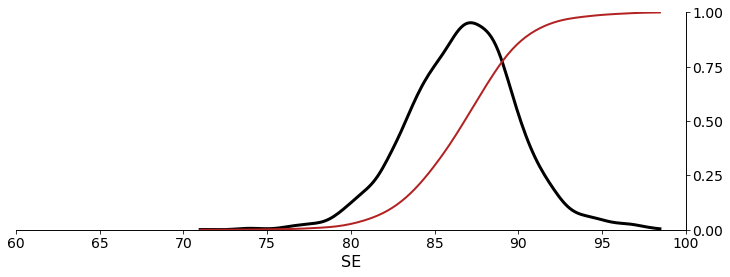

In [18]:
plot_distribution(fbsq,"se",xlim=[60,100])

Here, we just say the SE is good (1) when above 85%, otherwise it is bad (0).

In [19]:
def encode_se(value):
    """returns encoded value for se"""
    if value >= 85:
        return 1
    else:
        return 0

## TST
Based on a "traditional" recommendations, we can lump `tst` into three categories:

| TST | Rating | Value |
| --- | --- | --- |
| >9 h | High | 0 |
| 7-9 h | Typical | 1 |
| <7 h | Low | 0 |

In [20]:
def encode_tst(value):
    """returns score of tsts"""
    if value > 9:
        return 0
    elif value >= 7:
        return 1
    else:
        return 0

## REM
Ideally you should be spending between 20% and 25% of your night in REM sleep.

In [21]:
def encode_rem(value):
    """returns score of REM percent"""
    if value >= 0.2 and value <= 0.25:
        return 1
    else:
        return 0

## Light Sleep
Light Sleep should be a maximum of about 60% but we also don't want too little. 

In [22]:
def encode_light(value):
    """returns score of light percent"""
    if value >= 0.4 and value <= 0.6:
        return 1
    else:
        return 0

## Deep Sleep
Deep sleep should encompass about 12% to 23% of your night.

In [23]:
def encode_deep(value):
    """returns score of deep percent"""
    if value >= 0.12 and value <= 0.23:
        return 1
    else:
        return 0

## SOL
The National Sleep Foundation says 30 minutes or less is a marker for good sleep quality. However, looking at the distribution of values, perhaps we should alter that threshold since many of the participants fall asleep faster than that.

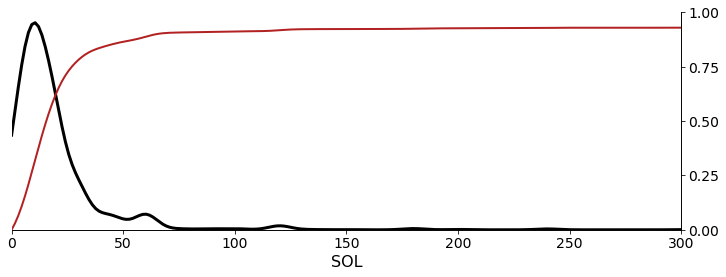

In [24]:
plot_distribution(srsq,"sol")

In [25]:
def encode_sol(value):
    """returns score of sol"""
    if value < 15:
        return 1
    else:
        return 0

## NAW
We group NAW into a good and bad category based on [Ohayon et al., 2017](https://www.sciencedirect.com/science/article/pii/S2352721816301309?casa_token=56p9duOGsL4AAAAA:tmPWLtzq0Z9zGGq-w0qWBXJT-VEDeoZ0dOwL06G-BwbWMHA3uT_KBjxd08HPyFZWNqIpm_0m).

| NAW | Rating | Value |
| --- | --- | --- |
| 0 or 1 | Good | 1 |
| >1 | Bad | 0 |

In [26]:
def encode_naw(value):
    """returns score of naw"""
    if value < 2:
        return 1
    else:
        return 0

## Restfulness
Restfulness is one of the five metrics that is rated on a 0 to 3 Likert scale. So we can create a more generic function here for later use.

In [27]:
def encode_likert(value):
    """returns score for a 0-3 Likert measurement"""
    if value > 1:
        return 1
    else:
        return 0

## Encoding Sleep Quality

### Self-Report Sleep
We start with self-report metrics of sleep quality.

In [28]:
for sm, f in zip(["tst","sol","naw","restful"], [encode_tst,encode_sol,encode_naw,encode_likert]):
    srsq[f"{sm}_binary"] = srsq.apply(lambda x: f(x[sm]), axis="columns")
    
srsq.head()

,timestamp,end_date,beiwe,redcap,beacon,tst,sol,naw,restful,tst_binary,sol_binary,naw_binary,restful_binary
0,2020-05-13 09:10:27,2020-05-13,qh34m4r9,68,19.0,8.0,20.0,2.0,3.0,1,0,0,1
1,2020-05-13 09:15:49,2020-05-13,awa8uces,28,26.0,2.0,10.0,3.0,1.0,0,1,0,0
2,2020-05-13 09:42:19,2020-05-13,xxvnhauv,21,22.0,6.0,30.0,3.0,1.0,0,0,0,0
3,2020-05-13 09:43:27,2020-05-13,rvhdl2la,29,NaN,5.3,5.0,2.0,2.0,0,1,0,1
4,2020-05-13 10:11:51,2020-05-13,q5y11ytm,48,NaN,2.0,10.0,0.0,0.0,0,1,1,0


### Fitbit Sleep
And now Fitbit-measured sleep quality.

In [29]:
for sm, f in zip(["tst","se","rem_percent","light_percent","deep_percent"], [encode_tst,encode_se,encode_rem,encode_light,encode_deep]):
    fbsq[f"{sm}_binary"] = fbsq.apply(lambda x: f(x[sm]), axis="columns")
    
fbsq.head()

,start_time,end_time,start_date,end_date,beiwe,redcap,beacon,tst,se,rem_percent,light_percent,deep_percent,tst_binary,se_binary,rem_percent_binary,light_percent_binary,deep_percent_binary
0,2020-05-14 00:27:00,2020-05-14 07:13:00,2020-05-14,2020-05-14,hfttkth7,NaN,NaN,6.316667,93.349754,0.216359,0.562005,0.221636,0,1,1,1,1
1,2020-05-14 23:53:30,2020-05-15 08:06:30,2020-05-14,2020-05-15,hfttkth7,NaN,NaN,6.533333,79.513185,0.119898,0.637755,0.242347,0,0,0,0,0
2,2020-05-15 23:28:00,2020-05-16 04:57:00,2020-05-15,2020-05-16,hfttkth7,NaN,NaN,4.783333,87.234043,0.174216,0.662021,0.163763,0,1,0,0,1
3,2020-05-17 02:01:30,2020-05-17 09:28:30,2020-05-17,2020-05-17,hfttkth7,NaN,NaN,6.716667,90.156600,0.205955,0.600496,0.193548,0,1,1,0,1
4,2020-05-18 00:24:00,2020-05-18 07:20:00,2020-05-18,2020-05-18,hfttkth7,NaN,NaN,5.850000,84.375000,0.250712,0.475783,0.273504,0,0,0,1,0


<a id="feature_engineering" ></a>

# Feature Engineering
In the following cells, we encode the various features to binary outcomes and combine the features into one dataset. 

## Encoding
We encode each of the features into a binary outcome.

### Activity

#### Activity Level
Encoding the activity levels can be accomplished by looking at recommendations from the American College of Sports Medicine. ACSM states that adults should do:
* Moderate Intensity: 150 - 300 minutes per week, or
* Vigorous: 75 - 150 minutes per week, or
* Combination

Fitbit divides activity level into multiple categories that are not exactly the same label as what the ACSM states. While the cutoff points are not very clear, they are most likely:
* Sedentary: MET < 1
* Light: MET < 3
* Fairly: MET < 6 (ACSM Moderate)
* Very: > 6 (ACSM Vigorous)

We look on a per-day basis so the cutoffs discussed above can be altered:
* Moderate: 21 - 43 minutes per day
* Vigorous: 11 - 21 minutes per day

We will start with what seems the most straightforward separation: getting enough moderate and vigorous activity per day. Based on the guidelines, one needs twice as many moderate minutes as vigorous minutes of activity. In order to address the "combination" category, we can multiply the number of vigorous minutes by 2 and add this value to the moderately active minutes which will allow us to compare this value to the moderately active minutes threshold. 

In [30]:
def encode_activity_level(row, moderate_threshold=30):
    """returns score of activity level"""
    if row["fairly_active_minutes"] + row["very_active_minutes"]*2 > moderate_threshold:
        return 1
    else:
        return 0

#### Number of Steps
An attainable goal that all adults should strive for is about 10,000 steps a day

In [31]:
def econde_steps(value):
    if value > 10000:
        return 1
    else:
        return 0

In [32]:
activity["active_binary"] = activity.apply(lambda row: encode_activity_level(row), axis="columns")
activity["steps_binary"] = activity.apply(lambda x: econde_steps(x["steps"]), axis="columns")
activity.head()

,date,beiwe,steps,sedentary_minutes,lightly_active_minutes,fairly_active_minutes,very_active_minutes,active_binary,steps_binary
0,2020-05-13,hfttkth7,9207,1241,70,118,11,1,0
1,2020-05-14,hfttkth7,15207,614,263,134,23,1,1
2,2020-05-15,hfttkth7,14556,577,205,57,108,1,1
3,2020-05-16,hfttkth7,18453,760,176,24,151,1,1
4,2020-05-17,hfttkth7,15425,605,207,50,131,1,1


### Mood
Each of the mood scores (except for `energy`) are on the same Likert scale as `restful` so we can just use that function to encode the mood scores. For `energy`, there are only two negative responses so we will consider the `Neutral` response as a positive score which allows us to use the same function.

In [33]:
for variable in ["content","stress","lonely","sad","energy"]:
    mood[f"{variable}_binary"] = mood.apply(lambda x: encode_likert(x[variable]), axis="columns")
    
mood.head()

,timestamp,beiwe,content,stress,lonely,sad,energy,redcap,beacon,date,content_binary,stress_binary,lonely_binary,sad_binary,energy_binary
0,2020-05-13 19:00:23,awa8uces,1.0,1.0,1.0,3.0,2.0,28,26.0,2020-05-13,0,0,0,1,1
1,2020-05-13 19:21:32,lkkjddam,0.0,2.0,3.0,1.0,0.0,12,21.0,2020-05-13,0,1,1,0,0
2,2020-05-13 19:30:38,rvhdl2la,2.0,1.0,0.0,0.0,1.0,29,NaN,2020-05-13,1,0,0,0,0
3,2020-05-13 20:07:04,xxvnhauv,1.0,3.0,1.0,2.0,0.0,21,22.0,2020-05-13,0,1,0,1,0
4,2020-05-13 20:25:07,xdbdrk6e,2.0,1.0,2.0,1.0,3.0,23,24.0,2020-05-13,1,0,1,0,1


### IEQ
For the IEQ data, we want to determine whether the concentrations are low or high depending on the participant's own environment. So the process will involve looking at each of the IEQ measurements from each participant, finding the mean of those nights, and then determining 1 (low) or 0 (high).

In [34]:
def encode_ieq(value, threshold):
    """Scores the IEQ parameter"""
    if value <= threshold:
        return 1
    else:
        return 0

In [37]:
ieq_bi = pd.DataFrame()
stat="median"
for pt in ieq["beiwe"].unique():
    ieq_pt = ieq[ieq["beiwe"] == pt]
    for pollutant in ["co2", "co","tvoc","pm2p5_mass","temperature_c","rh"]:#"no2"
        mean_night = np.nanmean(ieq_pt[f"{pollutant}_{stat}"])
        ieq_pt[f"{pollutant}_{stat}_binary"] = ieq_pt.apply(lambda x: encode_ieq(x[f"{pollutant}_{stat}"],mean_night), axis="columns")
        
    ieq_bi = ieq_bi.append(ieq_pt)
    
ieq_bi.head()

,beacon,beiwe,redcap,start_time,end_time,tvoc_median,lux_median,co_median,co2_median,pm2p5_mass_median,temperature_c_median,rh_median,co2_median_binary,co_median_binary,tvoc_median_binary,pm2p5_mass_median_binary,temperature_c_median_binary,rh_median_binary
0,1,kyj367pi,10,2020-06-10 23:05:00,2020-06-11 09:14:00,71.566667,4.958996e-16,1.607322,506.381100,4.176611,28.000000,39.483333,1,0,1,1,0,1
1,1,kyj367pi,10,2020-06-11 23:12:30,2020-06-12 09:14:30,216.916667,4.958996e-16,1.169600,530.170098,10.268426,27.500000,40.436667,1,0,1,0,1,1
2,1,kyj367pi,10,2020-06-17 22:55:30,2020-06-18 08:51:30,319.646667,4.958996e-16,0.591232,515.493173,5.591069,27.588333,45.706667,1,1,0,1,1,1
3,1,kyj367pi,10,2020-06-18 22:13:30,2020-06-19 08:42:00,309.186667,4.958996e-16,0.086787,496.541909,5.670253,28.450000,46.830000,1,1,0,1,0,1
4,1,kyj367pi,10,2020-06-20 23:06:30,2020-06-21 07:43:00,316.976667,4.958996e-16,0.247670,482.574615,3.976247,28.000000,47.862500,1,1,0,1,0,0


## Correcting EMA Timestamp
The EMAs are tricky because they can be submitted at any time. So we need to make sure that the `date` column we merge along corresponds to the correct end date of the Fitbit sleep event. 

In [38]:
def correct_ema_date(ema, fbs, threshold=3, verbose=True):
    """adds new column corresponding to the day when the participant woke"""
    ema_with_dates = pd.DataFrame()
    for pt in ema["beiwe"].unique():
        end_dates = []
        if verbose:
            print("Participant:", pt)
        # getting data per participant
        ema_pt = ema[ema["beiwe"] == pt]
        try:
            fb_pt = fbs[fbs["beiwe"] == pt]
        except KeyError:
            if verbose:
                print("\tNo Fitbit Data")
            continue
        # looping through submission times
        for submission_time in ema_pt["timestamp"]:
            end_dates.append(np.nan) # appending to keep same length
            fb_since = fb_pt[fb_pt["start_time"] > submission_time] # Fitbit sleep data since the EMA was submitted
            try:
                dt = fb_since["start_time"].iloc[0] - submission_time # get time difference between when the EMA was submitted and the Fitbit started logging data
            except IndexError:
                if verbose:
                    print("\tNo Fitbit Data after EMA submission of", submission_time.date())
                continue
            if dt < timedelta(hours=threshold): # if the EMA was submitted a certain time before the sleep event, add the actual date
                if submission_time.hour > 12:
                    end_dates[-1] = submission_time.date() + timedelta(days=1)
                else:
                    end_dates[-1] = submission_time.date()
                    
        ema_pt["end_date"] = pd.to_datetime(end_dates)
        if verbose:
            print((ema_pt["date"] == ema_pt["end_date"]).value_counts())
            print()
        ema_with_dates = ema_with_dates.append(ema_pt)
        
    return ema_with_dates

We get a new mood dataframe with the `end_date` column which we will merge along.

In [39]:
new_mood = correct_ema_date(mood, fbsq, threshold=5, verbose=False)

## Correcting Activity Date
The activity date corresponds to the day on which the participant was that active. Since all the other dates are relative to when the participant wakes up, we have to add a day to the activity data.

In [40]:
activity["end_date"] = activity["date"] + timedelta(days=1)

## Combining
Now that we have encoded all the target variables, we can combine them in different datasets to get a better sense of the available data for prediction. The common link between all the datasets will be the IEQ dataset since we are aiming to use those variables as a novel approach to prediction.

### IEQ Only
Considering the base case: just IEQ observations.

In [41]:
print("Number of observations:",len(ieq_bi))

Number of observations: 551


### Activity and IEQ

In [42]:
ieq_bi["end_date"] = pd.to_datetime(ieq_bi["end_time"].dt.date)
ieq_and_activity = ieq_bi.merge(right=activity,on=["end_date","beiwe"])
print("Number of observations:",len(ieq_and_activity))

Number of observations: 508


<div class="alert alert-block alert-success">
 
By including activity data, we lose 43 observations from the original target dataset. This percent loss might even be smaller considering we haven't combined the data with the target datasets yet.
    
</div>

### Mood and IEQ

In [43]:
ieq_and_mood = ieq_bi.merge(right=new_mood,on=["end_date","beiwe","redcap","beacon"])
print("Number of observations:",len(ieq_and_mood))

Number of observations: 115


<div class="alert alert-block alert-danger">
 
Unfortunately the mood data is too sparsely represented and _dramatically_ reduces the amount of observations that we have.
    
</div>

### Activity, Mood, and IEQ

In [44]:
features_all = ieq_and_activity.merge(right=new_mood, on=["end_date","beiwe","redcap","beacon"])
print("Number of observations:",len(features_all))

Number of observations: 103


<div class="alert alert-block alert-danger">
 
Now looping in all three feature sets, we see that we only hae 70 observations to work with and this is before merging with the target datasets which would cut down our dataset even more. 
    
</div>

<a id="exploration"></a>

# Data Exploration
Now that we have our features and targets, we can look at the data to get a better sense of what we can do with it.

We have to start by combining the features and targets so that we are looking at the finalized dataset.

In [45]:
# Fitbit
combined_fb = ieq_and_activity.merge(right=fbsq,on=["beiwe","end_date"])
combined_fb_simple = combined_fb[[column for column in combined_fb.columns if column.endswith("binary")]]
# Beiwe
combined_sr = ieq_and_activity.merge(right=srsq,on=["beiwe","end_date"])
combined_sr_simple = combined_sr[[column for column in combined_sr.columns if column.endswith("binary")]]

In [46]:
def plot_summary_count(df,variable):
    """plots the stripplot of a binary variable"""
    figure, ax = plt.subplots(figsize=(4,4))
    # count
    sns.countplot(x=variable,data=df,
                  edgecolor="black",ax=ax)
    # stats
    ax.text(0,len(df),f"Mean: {round(np.nanmean(df[variable]),2)}",va="top",ha="center",fontsize=14)
    # x-axis
    plt.xticks(fontsize=14)
    ax.set_xlabel(variable.split("_")[0].upper(),fontsize=16)
    # y-axis
    plt.yticks(fontsize=14)
    ax.set_ylabel("Count",fontsize=16)
    ax.set_ylim([0,len(df)])
    # remainder
    for loc in ["top","right"]:
        ax.spines[loc].set_visible(False)
    plt.show()
    plt.close()

## Summary of Features
We start with the features

## Summary of Targets
For the targets, our main concern is that we are getting equal representation from each of the responses. A lack of observations might lead to poorly performing models.

### Fitbit
Fitbit sleep targets and distribution of responses.

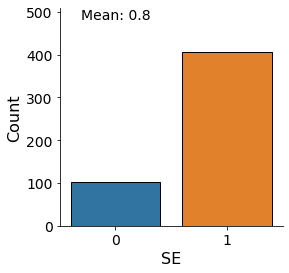

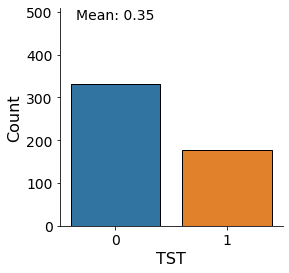

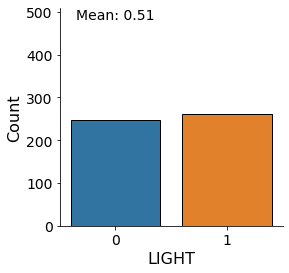

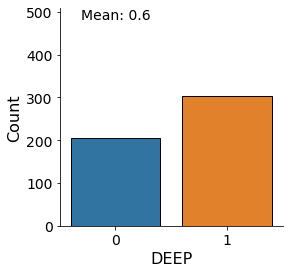

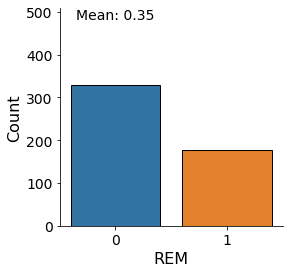

In [47]:
for fb_target in ["se","tst","light_percent","deep_percent","rem_percent"]:
    plot_summary_count(combined_fb_simple,f"{fb_target}_binary")

### Self-Report
And now for the self-report metrics

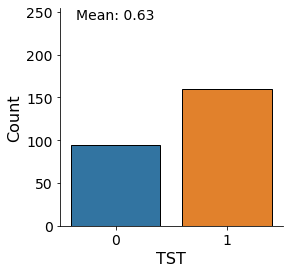

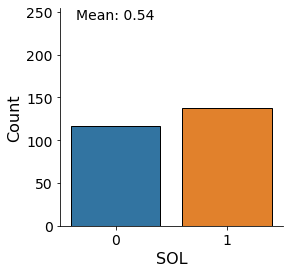

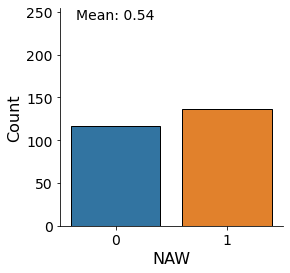

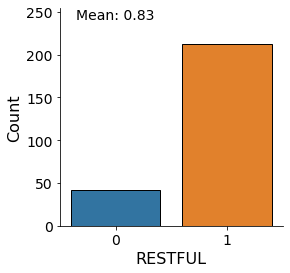

In [48]:
for sr_target in ["tst","sol","naw","restful"]:
    plot_summary_count(combined_sr_simple,f"{sr_target}_binary")

<a id="prediction"></a>

# Prediction
Now that we have sufficiently explored the features, we can begin to try predicting various components of sleep quality. We will try a wide-variety of classifiers to determine which is the most applicable to solving our problem. The classifiers that we use can be seen in the following cell via the `import` statements.

## Linear Regression
We use linear regression as a first step in the analysis.

In [49]:
from sklearn.linear_model import LinearRegression

In [50]:
class linear_model:
    
    def __init__(self):
        pass
    
    def set_x_and_y(self, feature_set, target_set, features=["co2_median","co_median","pm2p5_mass_median","no2_median","temperature_c_median","rh_median","steps","sedentary_minutes","lightly_active_minutes","fairly_active_minutes","very_active_minutes"], target="tst"):
        """sets the x and y parameters"""
        # for reference
        self.target_label = target
        self.feature_labels = features
        combined = feature_set.merge(right=target_set,on=["beiwe","end_date"])
        combined_simple = combined[[column for column in combined.columns if not column.endswith("binary") and not column.endswith("x") and not column.endswith("y")]]
        combined_simple.dropna(inplace=True)
        # getting x and y
        self.y = combined_simple[[f"{target}"]]
        self.X = combined_simple[[column for column in combined.columns if column.endswith("median") or column.endswith("minutes") or column == "steps"]]
        self.X = self.X[features]

    def set_model(self):
        """runs a linear leasts-squares regression model"""
        self.model = LinearRegression(normalize=True).fit(self.X,self.y)
        temp = pd.DataFrame(data={"feature":self.feature_labels,"coefficient":self.model.coef_[0]})
        self.coefficients = temp.sort_values("coefficient")
    
    def run(self, feature_set, target_set, features=["co2_median","co_median","pm2p5_mass_median","no2_median","temperature_c_median","rh_median","steps","sedentary_minutes","lightly_active_minutes","fairly_active_minutes","very_active_minutes"], target="tst"):
        """runs the linear model"""
        self.set_x_and_y(feature_set, target_set, features, target)
        self.set_model()
        print(self)
        
    def get_r2(self):
        """gets r2"""
        return round(self.model.score(self.X, self.y),3)
    
    def get_coefs(self):
        """gets coefficients of the model"""
        return self.coefficients
    
    def __str__(self):
        """output"""
        print("Linear Model")
        try:
            print("Observations:", len(self.X))
            print("Score:", self.get_r2())
            print("Coefficients:")
            for feature, c in zip(self.get_coefs().iloc[:,0], self.get_coefs().iloc[:,1]):
                print(f"\t{feature}:\t{round(c,4)}")
        except AttributeError:
            print("No Model found")
            
        return ""

### Aggregate
All the participants' data considered

In [52]:
lm = linear_model()
lm.run(ieq_and_activity, fbsq, features=["co2_median","co_median","pm2p5_mass_median","temperature_c_median","rh_median","steps","sedentary_minutes","lightly_active_minutes","fairly_active_minutes","very_active_minutes"])

Linear Model
Observations: 396
Score: 0.087
Coefficients:
	temperature_c_median:	-0.0573
	co_median:	-0.0412
	lightly_active_minutes:	-0.0028
	sedentary_minutes:	-0.0006
	steps:	-0.0
	co2_median:	0.0
	fairly_active_minutes:	0.0036
	very_active_minutes:	0.0062
	rh_median:	0.0068
	pm2p5_mass_median:	0.0335



## Classification

In [53]:
# Logistic Regressions
from sklearn.linear_model import LogisticRegression
# Random Forest
from sklearn.ensemble import RandomForestClassifier
# Bernoulli Naive Bayes
from sklearn.naive_bayes import BernoulliNB
# KNN
from sklearn.neighbors import KNeighborsClassifier
# Support Vector
from sklearn.svm import SVC
# Multi-Layer Perceptron
from sklearn.neural_network import MLPClassifier
# ADAboost
from sklearn.ensemble import AdaBoostClassifier
# Gradient Boost
from sklearn.ensemble import GradientBoostingClassifier
# Bagging
from sklearn.ensemble import BaggingClassifier

To automate the prediction/evaluation process, we have created the class below that utilizes the following steps:
1. Feature and Target Data Split: The feature and target datasets are fed into the program, cross-referenced, and then split.
2. Train/Test Split: Data are split into a training and a testing split

In [87]:
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

class ieq_and_sq_prediction:
    
    def __init__(self):
        """initializes the model parameters"""
        self.classifier_model_params_complete = {
            "logistic_regression": {
                "model":LogisticRegression(random_state=42,max_iter=500),
                "params": {
                    "fit_intercept":[True,False],
                    "solver":["lbfgs","liblinear"],
                }
            },
            "random_forest": {
                "model":RandomForestClassifier(random_state=42),
                "params": {
                    "n_estimators":[10,50,100],
                    "max_depth":[2,3,4,5],
                    "min_samples_split":[2,4],
                    "min_samples_leaf":[1,2],
                }
            },
            "bernoulli_naive_bayes": {
                "model":BernoulliNB(binarize=None),
                "params": {
                    "alpha":[0,0.5,1],
                }
            },
            "k-nearest_neighbor": {
                "model":KNeighborsClassifier(),
                "params": {
                    "n_neighbors":[3,5,7],
                    "weights":["uniform","distance"],
                    "p":[1,2],
                }
            },
            "support_vector": {
                "model":SVC(random_state=42),
                "params": {
                    "kernel":["linear","poly","sigmoid","rbf"],
                }
            },
            "multilayer_perceptron": {
                "model":MLPClassifier(random_state=42,solver="lbfgs",max_iter=500),
                "params": {
                    "hidden_layer_sizes":[1,10,50,100],
                    "activation":["identity","logistic"]
                }
            },
            "adaboost":{
                "model": AdaBoostClassifier(random_state=42),
                "params": {
                }
            },
            "gradientboost":{
                "model": GradientBoostingClassifier(random_state=42),
                "params": {
                    "max_depth":[1,2,3],
                }
            },
            "bagging":{
                "model":BaggingClassifier(random_state=42),
                "params": {
                    "n_estimators":[5,10,20],
                    "bootstrap_features":[False,True],
                }
            }
        }
        self.classifier_model_params = {
            "logistic_regression": {
                "model":LogisticRegression(random_state=42,max_iter=500),
                "params": {
                    "fit_intercept":[True,False],
                    "solver":["lbfgs","liblinear"],
                }
            },
            "random_forest": {
                "model":RandomForestClassifier(random_state=42),
                "params": {
                    "n_estimators":[10,50,100],
                    "max_depth":[2,3,4,5],
                    "min_samples_split":[2,4],
                    "min_samples_leaf":[1,2],
                }
            },
            "bernoulli_naive_bayes": {
                "model":BernoulliNB(binarize=None),
                "params": {
                    "alpha":[0,0.5,1],
                }
            },
            "k-nearest_neighbor": {
                "model":KNeighborsClassifier(),
                "params": {
                    "n_neighbors":[3,5,7],
                    "weights":["uniform","distance"],
                    "p":[1,2],
                }
            }
        }
    
    def get_features_and_targets(self, feature_set, target_set, target="tst"):
        """gets feature set and target set for the same observations"""
        self.target_label = target
        print(f"Getting Features and Target ({target})...")
        # selecting only important target
        target_set_reduced = target_set[["beiwe","end_date",f"{target}_binary"]]
        # combining datasets to get overlapping observations
        combined = feature_set.merge(right=target_set_reduced,on=["beiwe","end_date"])
        combined = combined.merge(right=combined["beiwe"].value_counts().rename("count"),left_on="beiwe",right_index=True,how="left")
        combined = combined[combined["count"] > 1]
        combined_simple = combined[[column for column in combined.columns if column.endswith("binary") or column in ["count","beiwe"]]]
        # splitting into features and targets
        targets = combined_simple[[f"{target}_binary"]]
        features = combined_simple.drop([f"{target}_binary","beiwe"],axis="columns")
        self.features = features
        self.targets = targets
        
    def split_data(self, test_size=0.33):
        """splits data into training and testing"""
        print("Splitting Data...")
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.features, self.targets, test_size=test_size, random_state=10, stratify=self.features["count"])
        self.X_train.drop("count",axis="columns",inplace=True)
        self.X_test.drop("count",axis="columns",inplace=True)
        
    def set_test_and_train(self,X_train,X_test,y_train,y_test):
        """sets the training data - use for specialized train_test_split"""
        for dataset in [X_train,X_test,y_train,y_test]:
            try: 
                dataset.drop(["count"],axis="columns",inplace=True)
            except KeyError:
                pass
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        
    def optimize_models(self):
        """runs gridsearch cv"""
        print("Testing Classifiers...")
        try:
            scores = []
            params = self.classifier_model_params
            for model_name, mp in params.items():
                s = datetime.now()
                print(f"\t{model_name.replace('_',' ').title()}")
                clf = GridSearchCV(mp["model"],mp["params"],cv=5,return_train_score=False)
                clf.fit(self.X_train,self.y_train)
                scores.append({
                    "model":model_name,
                    "best_score":clf.best_score_,
                    "best_params":clf.best_params_
                })
                print("\t\tElapsed Time:\t", datetime.now() - s)
                print(f"\t\tBest Score:\t{clf.best_score_}\n\t\tBest Params:\t{clf.best_params_}")

            results = pd.DataFrame(scores,columns=["model","best_score","best_params"])
            # getting and saving best model
            results.sort_values(["best_score"],ascending=False,inplace=True)
            self.results = results
            best = results.iloc[0,:]
            # outputting results
            print(f"\tBest Scoring Model:")
            print(f"\t\tModel:\t{best[0].replace('_',' ').title()}\n\t\tScore:\t{round(best[1],3)}\n\t\tParams:\t{best[2]}")
        except AttributeError:
            print("Training data do not exist - run split_data()")
        
    def train_model(self, model):
        """trains the specified model"""
        print("Training...")
        self.model = model # necessary if running functions separately
        try:
            self.X_train = self.X_train
            self.X_test = self.X_test
            self.model.fit(self.X_train,self.y_train)
        except AttributeError:
            print("Training data do not exist - run split_data()")
    
    def predict(self):
        """gets the predicted results based on the model provided for the given target"""
        print("Predicting...")
        try:
            self.predictions = self.model.predict(self.X_test)
            
            self.score = metrics.precision_score(self.y_test,self.predictions,average="weighted")

            scores = cross_val_score(self.model, self.X_train, self.y_train, cv=5, scoring='precision_weighted')
            print("\tCross Validation Scores:")
            for scr in scores:
                print(f"\t\t{round(scr,3)}")
            print(f"\tAverage:\t{round(scores.mean(),3)}")
            print(f"\tModel Score: {round(self.score,3)}")
        except AttributeError:
            print("Missing attributes - make sure you split the data and trained the model")
        
    def plot_confusion_matrix(self, save=False, target_label=""):
        """plots confusion matrix"""
        print("Evaluating...")
        # get confusion matrix
        cm = metrics.confusion_matrix(self.y_test,self.predictions)
        cm_df = pd.DataFrame(cm)
        # plot confusion matrix as heatmap
        fig, ax = plt.subplots(figsize=(5,4))
        sns.heatmap(cm_df,annot=True,cmap="Blues",ax=ax)
        ax.set_xlabel("Predicted Label",fontsize=16)
        ax.set_ylabel("True Label",fontsize=16)
        if save:
            plt.savefig(f"../../../Documents/sbac_2021/project/figures/confusion_matrix-{target_label}.pdf")
        plt.show()
        plt.close()
        
    def set_feature_importance(self,plot=False):
        """gets feature importance from classifier models"""
        try:
            # getting importance df
            importance = pd.DataFrame(data={"feature":[value.split('_')[0] for value in self.features.columns[:-1]],"importance":self.model.feature_importances_})
            importance.sort_values("importance",inplace=True)
            self.feature_importance = importance
            if plot:
                # getting color map
                my_cmap = plt.get_cmap("Blues")
                rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
                # plotting
                fig, ax = plt.subplots(figsize=(6,4))
                ax.barh(importance["feature"],importance["importance"],color=my_cmap(rescale(importance["importance"])),edgecolor="black",tick_label=[visualize.get_label(label) for label in importance["feature"]])
                # x-axis
                plt.xticks(fontsize=12)
                ax.set_xlabel("Importance",fontsize=14)
                # y-axis
                plt.yticks(fontsize=12)
                ax.set_ylabel("Feature",fontsize=14)
                # remainder
                for loc in ["top","right"]:
                    ax.spines[loc].set_visible(False)
                plt.show()
                plt.close()
        except AttributeError as e:
            print(e)
            
    def run(self, feature_set, target_set, target="tst", test_size=0.33):
        """runs the class: split, test, predict, evaluate"""
        self.get_features_and_targets(feature_set, target_set, target=target)
        self.split_data(test_size=test_size)
        # gridsearch on models
        self.optimize_models()
        # saves the best model, trains on the best model, predicts with the model, and plots the confusion matrix
        for model_number in range(len(self.results)):
            print(self.results.iloc[model_number,0].replace("_"," ").upper())
            self.model = self.classifier_model_params[self.results.iloc[model_number,:]["model"]]["model"].set_params(**self.results.iloc[model_number,:]["best_params"])
            self.train_model(self.model)
            self.predict()
            self.plot_confusion_matrix()
            self.set_feature_importance(plot=True)
            
            
            

### Aggregate
All the participants' data considered and stratified according to the number of observations.

Getting Features and Target (se)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.132849
		Best Score:	0.8058823529411765
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:16.447754
		Best Score:	0.8058823529411765
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.063799
		Best Score:	0.8058823529411765
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.395409
		Best Score:	0.7882352941176471
		Best Params:	{'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Logistic Regression
		Score:	0.806
		Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
Training...
Predicting...
	Cross Validation Scores:
		0.654
		0.654
		0.654
		0.654
		0.631
	Average:	0.649
	Model Score: 0.608
Evaluating...


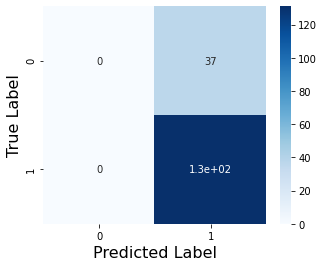

'LogisticRegression' object has no attribute 'feature_importances_'
Training...
Predicting...
	Cross Validation Scores:
		0.654
		0.654
		0.654
		0.654
		0.631
	Average:	0.649
	Model Score: 0.608
Evaluating...


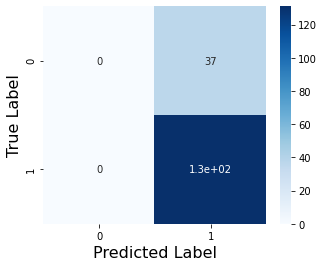

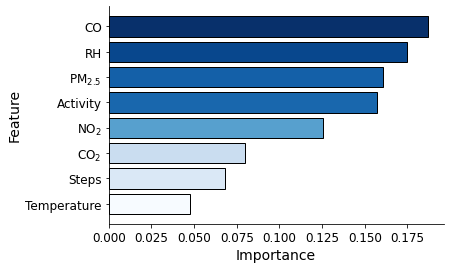

Training...
Predicting...
	Cross Validation Scores:
		0.654
		0.654
		0.654
		0.654
		0.631
	Average:	0.649
	Model Score: 0.608
Evaluating...


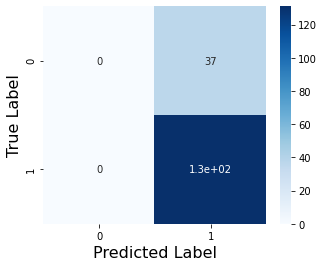

'BernoulliNB' object has no attribute 'feature_importances_'
Training...
Predicting...
	Cross Validation Scores:
		0.765
		0.723
		0.645
		0.757
		0.628
	Average:	0.704
	Model Score: 0.652
Evaluating...


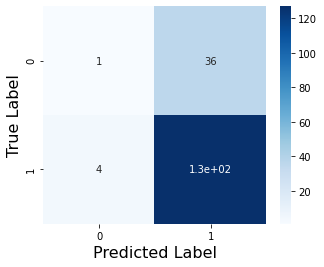

'KNeighborsClassifier' object has no attribute 'feature_importances_'
Getting Features and Target (tst)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.152785
		Best Score:	0.6823529411764706
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:18.387527
		Best Score:	0.6764705882352942
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.063978
		Best Score:	0.6705882352941177
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.399336
		Best Score:	0.65
		Best Params:	{'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Logistic Regression
		Score:	0.682
		Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
Training...
Predicting...
	Cross Validation Scores:
		0.788
		0.458
		0.788
		0.458
		0.458
	Average:	0.59
	Model Score: 0.566
Evaluating...


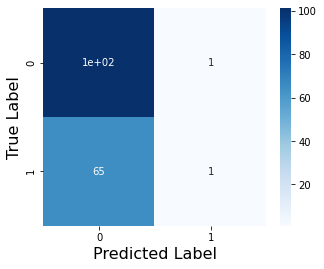

'LogisticRegression' object has no attribute 'feature_importances_'
Training...
Predicting...
	Cross Validation Scores:
		0.458
		0.458
		0.458
		0.458
		0.458
	Average:	0.458
	Model Score: 0.369
Evaluating...


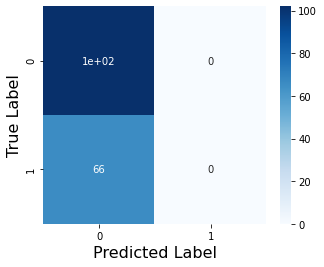

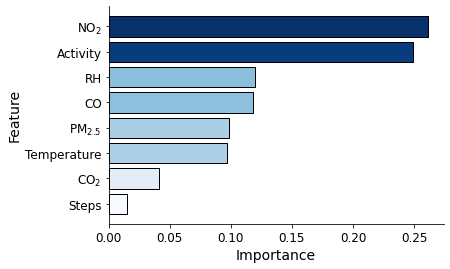

Training...
Predicting...
	Cross Validation Scores:
		0.458
		0.458
		0.458
		0.458
		0.566
	Average:	0.479
	Model Score: 0.369
Evaluating...


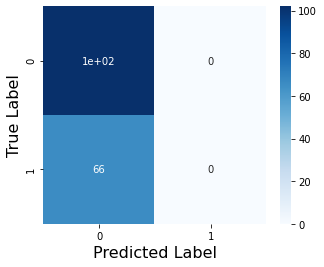

'BernoulliNB' object has no attribute 'feature_importances_'
Training...
Predicting...
	Cross Validation Scores:
		0.604
		0.59
		0.631
		0.501
		0.635
	Average:	0.592
	Model Score: 0.615
Evaluating...


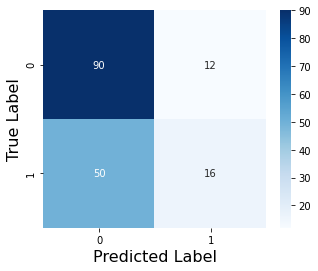

'KNeighborsClassifier' object has no attribute 'feature_importances_'
Getting Features and Target (light_percent)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.160832
		Best Score:	0.511764705882353
		Best Params:	{'fit_intercept': False, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:17.798081
		Best Score:	0.5617647058823529
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.065319
		Best Score:	0.5029411764705882
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.491809
		Best Score:	0.5117647058823529
		Best Params:	{'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.562
		Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
Training...
Predicting...
	Cross Validation Scores:
		0.558
		0.54
		0.649
		0.488
		0.634
	Average:	

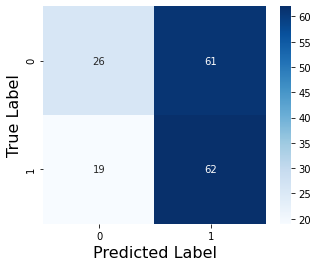

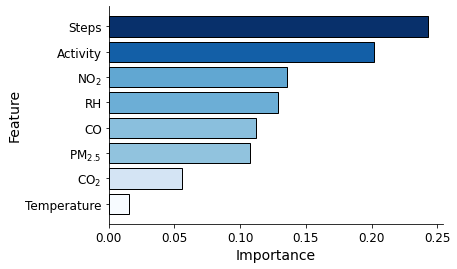

Training...
Predicting...
	Cross Validation Scores:
		0.502
		0.491
		0.591
		0.478
		0.492
	Average:	0.511
	Model Score: 0.528
Evaluating...


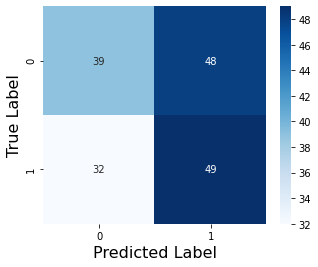

'LogisticRegression' object has no attribute 'feature_importances_'
Training...
Predicting...
	Cross Validation Scores:
		0.402
		0.502
		0.587
		0.552
		0.516
	Average:	0.512
	Model Score: 0.597
Evaluating...


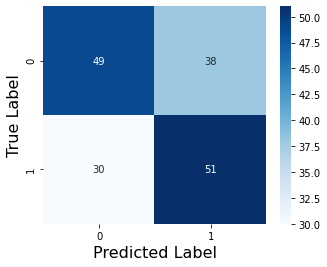

'KNeighborsClassifier' object has no attribute 'feature_importances_'
Training...
Predicting...
	Cross Validation Scores:
		0.492
		0.529
		0.54
		0.418
		0.49
	Average:	0.494
	Model Score: 0.534
Evaluating...


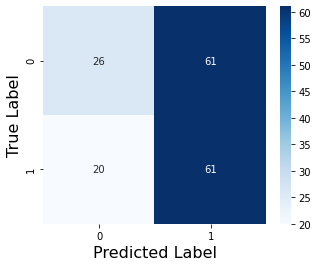

'BernoulliNB' object has no attribute 'feature_importances_'
Getting Features and Target (deep_percent)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.129358
		Best Score:	0.5882352941176471
		Best Params:	{'fit_intercept': False, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:18.016403
		Best Score:	0.5941176470588235
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.068055
		Best Score:	0.5970588235294118
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.450036
		Best Score:	0.5735294117647058
		Best Params:	{'n_neighbors': 7, 'p': 2, 'weights': 'distance'}
	Best Scoring Model:
		Model:	Bernoulli Naive Bayes
		Score:	0.597
		Params:	{'alpha': 0}
Training...
Predicting...
	Cross Validation Scores:
		0.587
		0.559
		0.578
		0.565
		0.578
	Average:	0.573
	Model Score: 0.559
Evaluating...


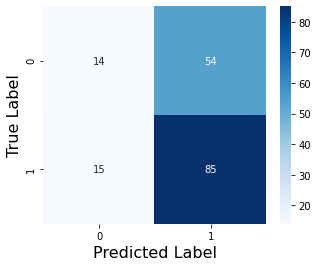

'BernoulliNB' object has no attribute 'feature_importances_'
Training...
Predicting...
	Cross Validation Scores:
		0.346
		0.346
		0.36
		0.364
		0.364
	Average:	0.356
	Model Score: 0.354
Evaluating...


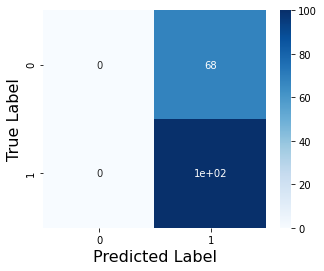

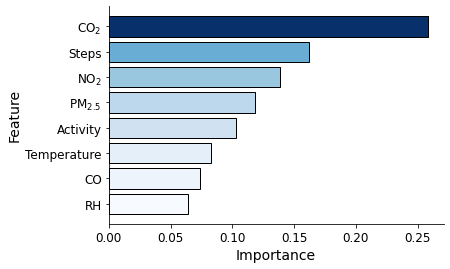

Training...
Predicting...
	Cross Validation Scores:
		0.551
		0.659
		0.514
		0.548
		0.544
	Average:	0.563
	Model Score: 0.534
Evaluating...


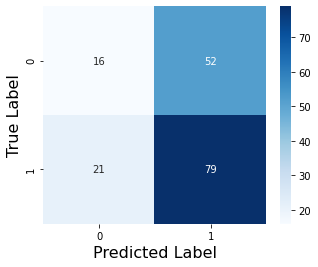

'LogisticRegression' object has no attribute 'feature_importances_'
Training...
Predicting...
	Cross Validation Scores:
		0.528
		0.64
		0.529
		0.548
		0.611
	Average:	0.571
	Model Score: 0.549
Evaluating...


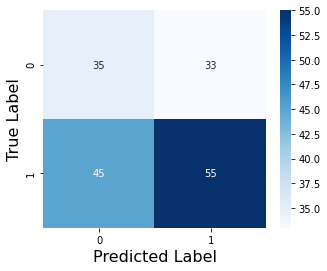

'KNeighborsClassifier' object has no attribute 'feature_importances_'
Getting Features and Target (rem_percent)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.146859
		Best Score:	0.661764705882353
		Best Params:	{'fit_intercept': True, 'solver': 'liblinear'}
	Random Forest
		Elapsed Time:	 0:00:18.646198
		Best Score:	0.6676470588235294
		Best Params:	{'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.063730
		Best Score:	0.6382352941176471
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.403318
		Best Score:	0.6323529411764707
		Best Params:	{'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.668
		Params:	{'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
Training...
Predicting...
	Cross Validation Scores:
		0.55
		0.62
		0.724
		0.743
		0.635
	Average:	

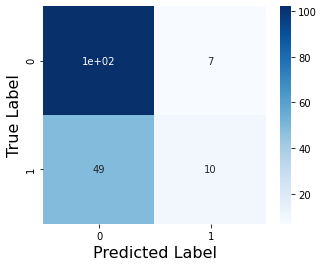

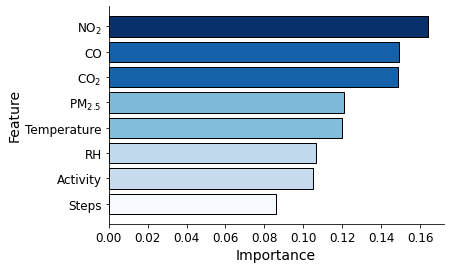

Training...
Predicting...
	Cross Validation Scores:
		0.551
		0.637
		0.419
		0.805
		0.562
	Average:	0.595
	Model Score: 0.628
Evaluating...


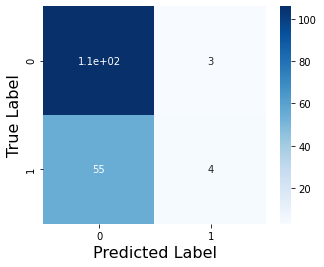

'LogisticRegression' object has no attribute 'feature_importances_'
Training...
Predicting...
	Cross Validation Scores:
		0.531
		0.575
		0.791
		0.698
		0.505
	Average:	0.62
	Model Score: 0.537
Evaluating...


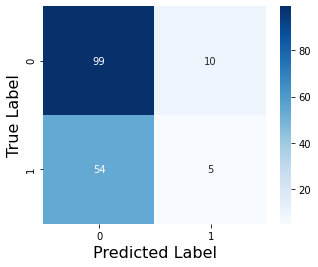

'BernoulliNB' object has no attribute 'feature_importances_'
Training...
Predicting...
	Cross Validation Scores:
		0.655
		0.596
		0.611
		0.693
		0.533
	Average:	0.618
	Model Score: 0.621
Evaluating...


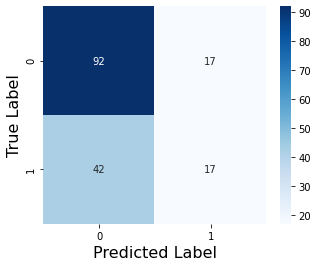

'KNeighborsClassifier' object has no attribute 'feature_importances_'


In [55]:
trial = ieq_and_sq_prediction()
for fb_target in ["se","tst","light_percent","deep_percent","rem_percent"]:
    trial.run(ieq_and_activity,fbsq,fb_target)

Getting Features and Target (tst)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.147521
		Best Score:	0.657397504456328
		Best Params:	{'fit_intercept': False, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:17.481665
		Best Score:	0.7224598930481283
		Best Params:	{'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.065133
		Best Score:	0.6631016042780749
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.408747
		Best Score:	0.6458110516934047
		Best Params:	{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
	Support Vector
		Elapsed Time:	 0:00:00.129198
		Best Score:	0.663458110516934
		Best Params:	{'kernel': 'rbf'}
	Multilayer Perceptron
		Elapsed Time:	 0:00:03.186778
		Best Score:	0.6688057040998219
		Best Params:	{'activation': 'logistic', 'hidden_layer_sizes': 1}
	Adaboost
		Elapsed Time:	 0:00:00.396625
		Best Score:	0.61568627

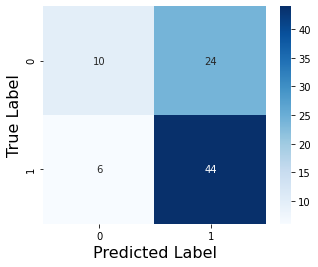

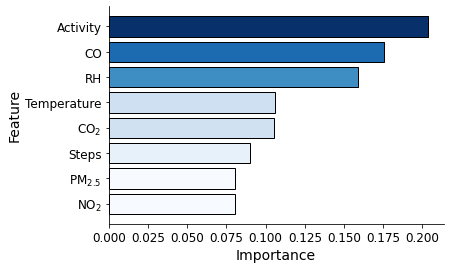

Getting Features and Target (sol)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.111073
		Best Score:	0.544741532976827
		Best Params:	{'fit_intercept': True, 'solver': 'liblinear'}
	Random Forest
		Elapsed Time:	 0:00:16.266708
		Best Score:	0.5857397504456329
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.066805
		Best Score:	0.5680926916221034
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.358627
		Best Score:	0.5499108734402852
		Best Params:	{'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
	Support Vector
		Elapsed Time:	 0:00:00.097335
		Best Score:	0.5921568627450979
		Best Params:	{'kernel': 'sigmoid'}
	Multilayer Perceptron
		Elapsed Time:	 0:00:03.152372
		Best Score:	0.544385026737968
		Best Params:	{'activation': 'identity', 'hidden_layer_sizes': 1}
	Adaboost
		Elapsed Time:	 0:00:00.393063
		Best Score:	0.5

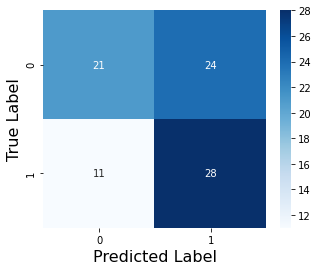

'SVC' object has no attribute 'feature_importances_'
Getting Features and Target (naw)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.129763
		Best Score:	0.5445632798573975
		Best Params:	{'fit_intercept': True, 'solver': 'liblinear'}
	Random Forest
		Elapsed Time:	 0:00:16.260671
		Best Score:	0.586096256684492
		Best Params:	{'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.063788
		Best Score:	0.5270944741532977
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.356295
		Best Score:	0.6155080213903743
		Best Params:	{'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
	Support Vector
		Elapsed Time:	 0:00:00.097331
		Best Score:	0.562210338680927
		Best Params:	{'kernel': 'rbf'}
	Multilayer Perceptron
		Elapsed Time:	 0:00:02.578868
		Best Score:	0.5563279857397505
		Best Params:	{'activation': 'identity', 'hidden_layer_sizes': 1}
	Adaboost

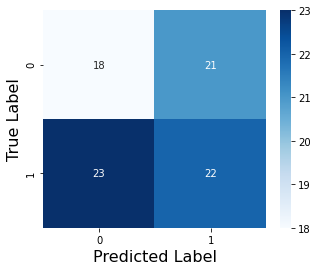

'KNeighborsClassifier' object has no attribute 'feature_importances_'
Getting Features and Target (restful)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.135100
		Best Score:	0.8344028520499108
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:16.308051
		Best Score:	0.8344028520499108
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.068818
		Best Score:	0.8344028520499108
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.370769
		Best Score:	0.8108734402852049
		Best Params:	{'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
	Support Vector
		Elapsed Time:	 0:00:00.097371
		Best Score:	0.8344028520499108
		Best Params:	{'kernel': 'linear'}
	Multilayer Perceptron
		Elapsed Time:	 0:00:03.604061
		Best Score:	0.8344028520499108
		Best Params:	{'activation': 'identity', 'hidden_layer

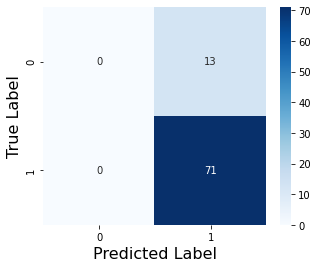

'LogisticRegression' object has no attribute 'feature_importances_'


In [47]:
trial = ieq_and_sq_prediction()
for sr_target in ["tst","sol","naw","restful"]:
    trial.run(ieq_and_activity,srsq,sr_target)

### Per Participant
Now we try another model where we considering only 1 participant, train on a subset of their data and see about predicting their sleep quality.

We first have to identify applicable participants. After an initial inspection, there seems to be a good cutoff of about **30 nights** that would give us a minimum of 20 nights for training and 10 for testing.

In [77]:
n_nights_by_pt = ieq_and_activity[["start_time","beiwe"]].groupby("beiwe").count().sort_values("start_time",ascending=False)
n_nights_gt30 = n_nights_by_pt[n_nights_by_pt["start_time"] >= 30]
n_nights_gt30

,start_time
beiwe,
tlmlq19s,68
lkkjddam,51
qh34m4r9,45
tmexej5v,39
kyj367pi,33
vr9j5rry,32
awa8uces,32
itmylz3g,31


<div class="alert alert-block alert-success">
 
This formulation gives us 8 participants to consider.
    
</div>

In [80]:
ieq_and_activity_gt30 = ieq_and_activity[ieq_and_activity["beiwe"].isin(n_nights_gt30.index)]

#### Fitbit Sleep Quality Classification
Now that we have the 8 participants identified, we can run the classification models.

KYJ367PI
Getting Features and Target (se)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.123437
		Best Score:	0.82
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:16.601481
		Best Score:	0.82
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.062373
		Best Score:	0.76
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.332249
		Best Score:	0.82
		Best Params:	{'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Logistic Regression
		Score:	0.82
		Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.64
		0.64
		1.0
		0.562
		0.562
	Average:	0.681
	Model Score: 0.669
Evaluating...


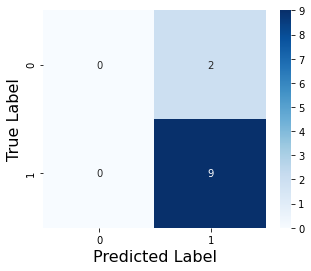

'LogisticRegression' object has no attribute 'feature_importances_'
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.64
		0.64
		1.0
		0.562
		0.562
	Average:	0.681
	Model Score: 0.669
Evaluating...


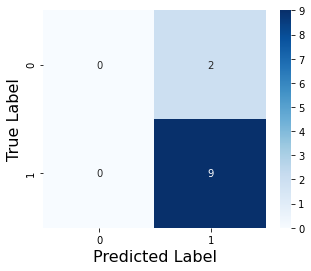

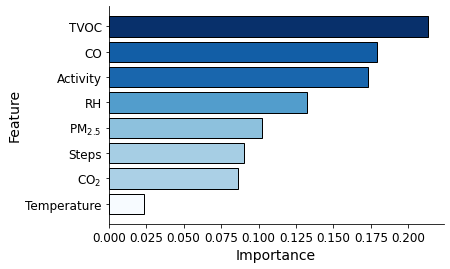

K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.64
		0.64
		1.0
		0.562
		0.562
	Average:	0.681
	Model Score: 0.669
Evaluating...


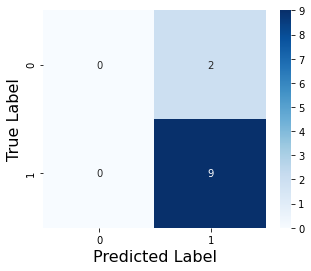

'KNeighborsClassifier' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.64
		1.0
		1.0
		0.375
		0.562
	Average:	0.716
	Model Score: 0.918
Evaluating...


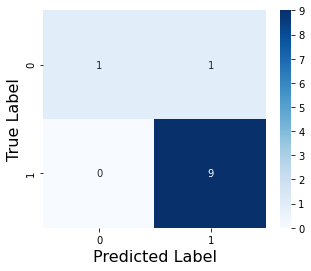

'BernoulliNB' object has no attribute 'feature_importances_'
Getting Features and Target (tst)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.112983
		Best Score:	0.43
		Best Params:	{'fit_intercept': False, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:15.946031
		Best Score:	0.5700000000000001
		Best Params:	{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.062453
		Best Score:	0.3
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.340276
		Best Score:	0.58
		Best Params:	{'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
	Best Scoring Model:
		Model:	K-Nearest Neighbor
		Score:	0.58
		Params:	{'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.6
		0.85
		0.833
		0.167
		0.5
	Average:	0.59
	Model Score: 0.57
Evaluating...


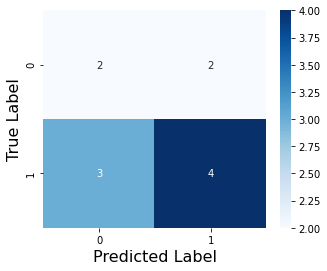

'KNeighborsClassifier' object has no attribute 'feature_importances_'
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.85
		0.85
		0.5
		0.167
		0.5
	Average:	0.573
	Model Score: 0.519
Evaluating...


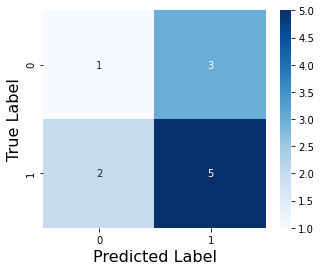

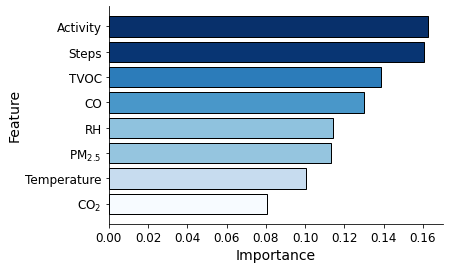

LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.8
		0.85
		0.0
		0.167
		0.5
	Average:	0.463
	Model Score: 0.606
Evaluating...


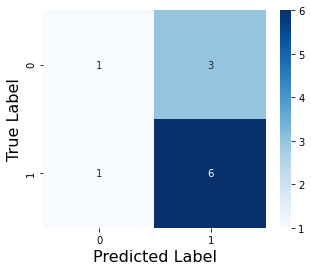

'LogisticRegression' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.433
		0.36
		0.167
		0.0
		0.375
	Average:	0.267
	Model Score: 0.72
Evaluating...


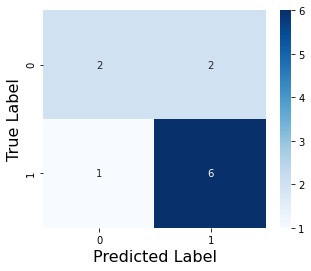

'BernoulliNB' object has no attribute 'feature_importances_'
Getting Features and Target (light_percent)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.112567
		Best Score:	0.73
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:15.830409
		Best Score:	0.73
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.063628
		Best Score:	0.6900000000000001
		Best Params:	{'alpha': 0.5}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.329175
		Best Score:	0.73
		Best Params:	{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Logistic Regression
		Score:	0.73
		Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.64
		0.36
		0.562
		0.562
		0.562
	Average:	0.538
	Model Score: 0.669
Evaluating...


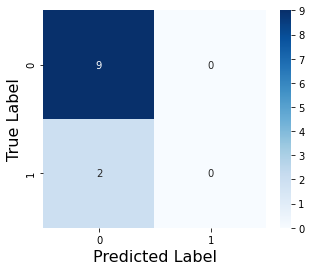

'LogisticRegression' object has no attribute 'feature_importances_'
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.64
		0.36
		0.562
		0.562
		0.562
	Average:	0.538
	Model Score: 0.636
Evaluating...


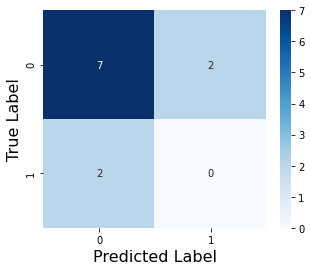

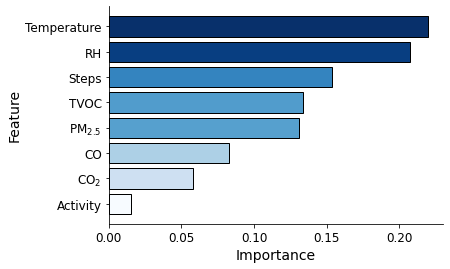

K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.64
		0.36
		0.562
		0.562
		0.562
	Average:	0.538
	Model Score: 0.655
Evaluating...


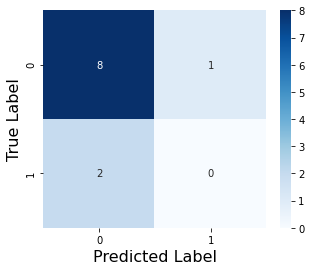

'KNeighborsClassifier' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.6
		0.36
		0.562
		0.875
		0.562
	Average:	0.592
	Model Score: 0.636
Evaluating...


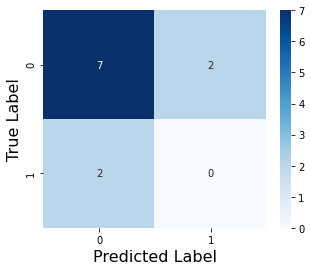

'BernoulliNB' object has no attribute 'feature_importances_'
Getting Features and Target (deep_percent)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.110437
		Best Score:	0.77
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:15.832546
		Best Score:	0.82
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.063350
		Best Score:	0.77
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.330381
		Best Score:	0.82
		Best Params:	{'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.82
		Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.64
		0.64
		1.0
		0.562
		0.562
	Average:	0.681
	Model Score: 0.405
Evaluating...


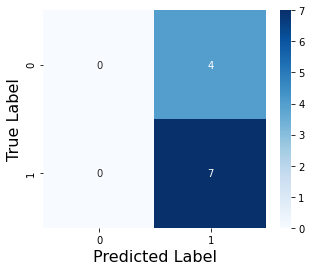

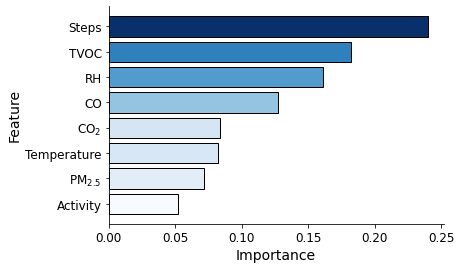

K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.64
		0.64
		1.0
		0.562
		0.562
	Average:	0.681
	Model Score: 0.382
Evaluating...


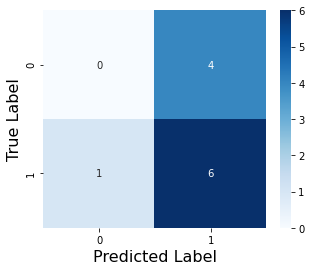

'KNeighborsClassifier' object has no attribute 'feature_importances_'
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.64
		0.64
		1.0
		0.562
		0.562
	Average:	0.681
	Model Score: 0.382
Evaluating...


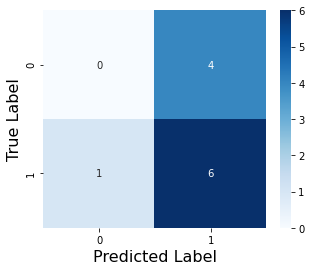

'LogisticRegression' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.64
		0.64
		1.0
		0.833
		0.562
	Average:	0.735
	Model Score: 0.354
Evaluating...


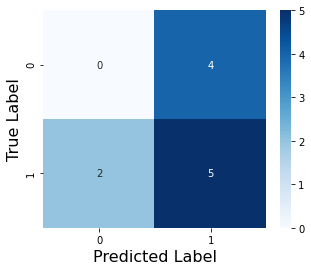

'BernoulliNB' object has no attribute 'feature_importances_'
Getting Features and Target (rem_percent)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.110414
		Best Score:	0.82
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:15.818239
		Best Score:	0.82
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.062947
		Best Score:	0.78
		Best Params:	{'alpha': 0.5}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.330974
		Best Score:	0.82
		Best Params:	{'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
	Best Scoring Model:
		Model:	Logistic Regression
		Score:	0.82
		Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.64
		0.64
		1.0
		0.562
		0.562
	Average:	0.681
	Model Score: 0.405
Evaluating...


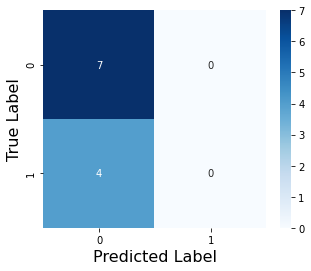

'LogisticRegression' object has no attribute 'feature_importances_'
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.64
		0.64
		1.0
		0.562
		0.562
	Average:	0.681
	Model Score: 0.405
Evaluating...


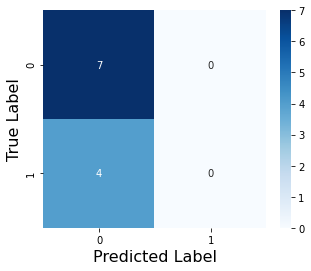

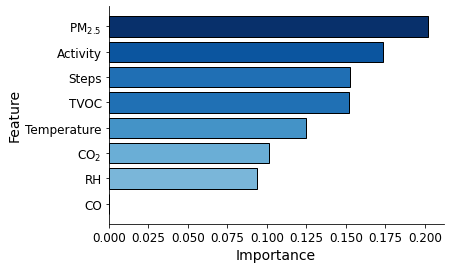

K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.64
		0.64
		1.0
		0.562
		0.562
	Average:	0.681
	Model Score: 0.382
Evaluating...


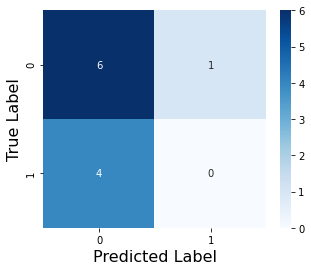

'KNeighborsClassifier' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.6
		0.64
		1.0
		0.562
		0.562
	Average:	0.673
	Model Score: 0.405
Evaluating...


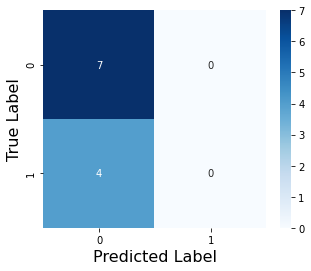

'BernoulliNB' object has no attribute 'feature_importances_'
ITMYLZ3G
Getting Features and Target (se)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.112993
		Best Score:	0.75
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:15.895094
		Best Score:	0.8
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.063404
		Best Score:	0.65
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.328713
		Best Score:	0.8
		Best Params:	{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.8
		Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		1.0
		0.562
		1.0
		0.833
		0.25
	Average:	0.729
	Model Score: 0.715
Evaluating...


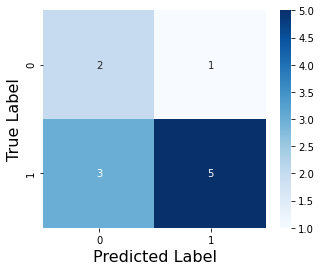

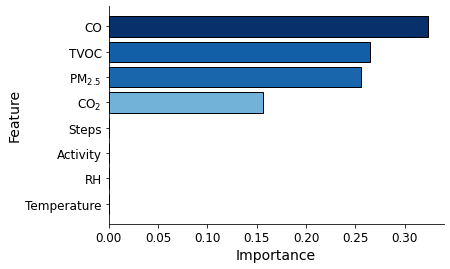

K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		1.0
		0.562
		1.0
		0.833
		0.25
	Average:	0.729
	Model Score: 0.539
Evaluating...


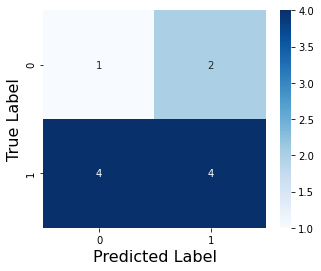

'KNeighborsClassifier' object has no attribute 'feature_importances_'
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.562
		0.562
		1.0
		0.833
		0.25
	Average:	0.642
	Model Score: 0.636
Evaluating...


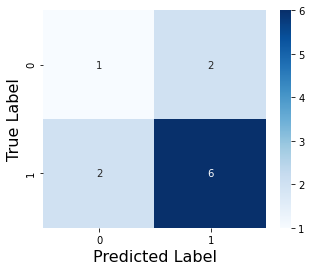

'LogisticRegression' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		1.0
		0.5
		1.0
		0.25
		0.167
	Average:	0.583
	Model Score: 0.588
Evaluating...


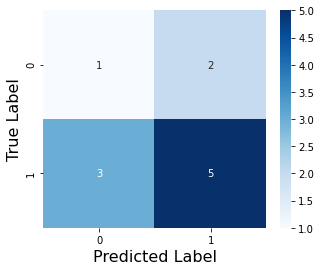

'BernoulliNB' object has no attribute 'feature_importances_'
Getting Features and Target (tst)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.104528
		Best Score:	0.7
		Best Params:	{'fit_intercept': False, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:15.894386
		Best Score:	0.65
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.063677
		Best Score:	0.55
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.328786
		Best Score:	0.65
		Best Params:	{'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Logistic Regression
		Score:	0.7
		Params:	{'fit_intercept': False, 'solver': 'lbfgs'}
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.25
		0.5
		1.0
		0.562
		0.562
	Average:	0.575
	Model Score: 0.485
Evaluating...


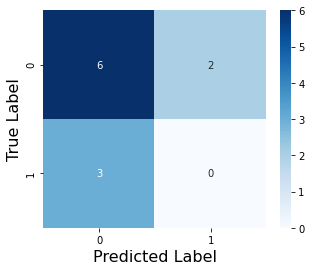

'LogisticRegression' object has no attribute 'feature_importances_'
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.25
		0.5
		0.562
		0.562
		0.562
	Average:	0.488
	Model Score: 0.818
Evaluating...


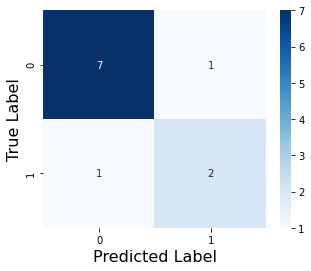

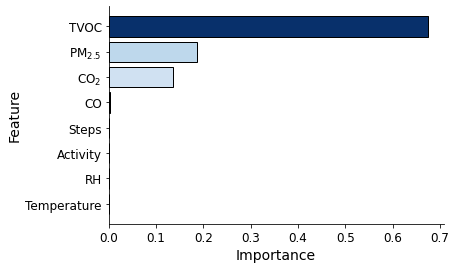

K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.25
		0.562
		0.5
		0.562
		0.562
	Average:	0.488
	Model Score: 0.715
Evaluating...


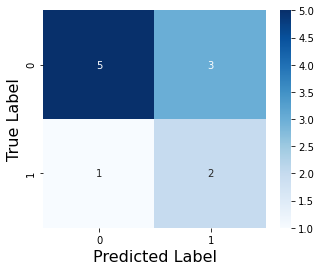

'KNeighborsClassifier' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.25
		0.5
		0.5
		0.562
		0.5
	Average:	0.462
	Model Score: 0.636
Evaluating...


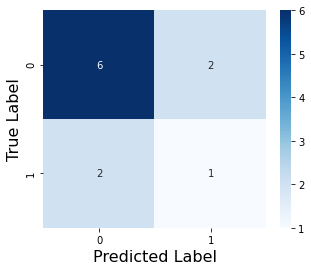

'BernoulliNB' object has no attribute 'feature_importances_'
Getting Features and Target (light_percent)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.108372
		Best Score:	0.45
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:15.816708
		Best Score:	0.45
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.062484
		Best Score:	0.45
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.332076
		Best Score:	0.4
		Best Params:	{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Logistic Regression
		Score:	0.45
		Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.5
		0.25
		0.5
		0.167
		0.25
	Average:	0.333
	Model Score: 0.539
Evaluating...


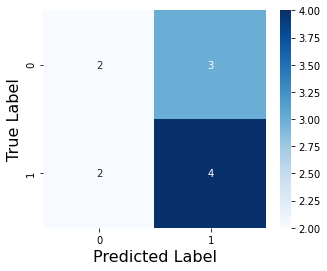

'LogisticRegression' object has no attribute 'feature_importances_'
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.875
		0.25
		0.5
		0.167
		0.167
	Average:	0.392
	Model Score: 0.555
Evaluating...


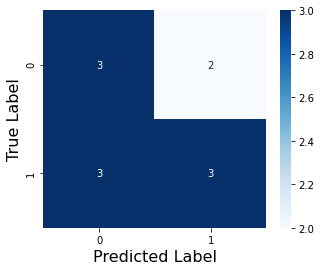

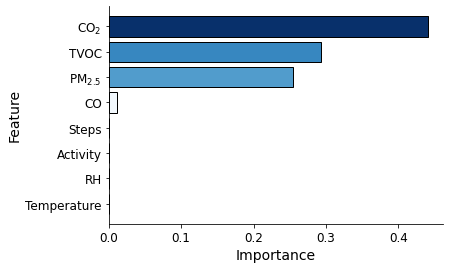

BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.5
		0.833
		0.5
		0.167
		0.167
	Average:	0.433
	Model Score: 0.455
Evaluating...


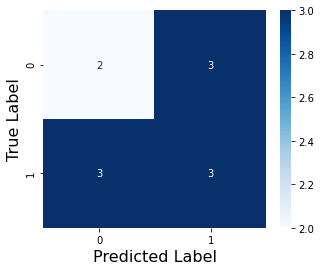

'BernoulliNB' object has no attribute 'feature_importances_'
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.375
		0.167
		0.5
		0.25
		0.25
	Average:	0.308
	Model Score: 0.455
Evaluating...


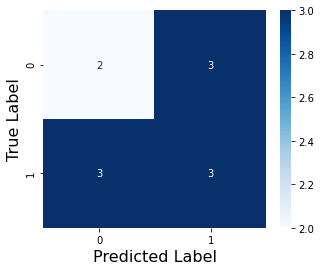

'KNeighborsClassifier' object has no attribute 'feature_importances_'
Getting Features and Target (deep_percent)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.111531
		Best Score:	0.6
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:15.888682
		Best Score:	0.55
		Best Params:	{'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.063127
		Best Score:	0.55
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.332253
		Best Score:	0.55
		Best Params:	{'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
	Best Scoring Model:
		Model:	Logistic Regression
		Score:	0.6
		Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.875
		0.833
		0.25
		0.25
		0.5
	Average:	0.542
	Model Score: 0.83
Evaluating...


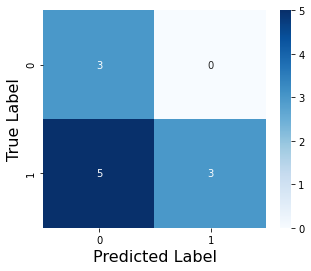

'LogisticRegression' object has no attribute 'feature_importances_'
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.875
		0.25
		0.25
		0.25
		0.5
	Average:	0.425
	Model Score: 0.864
Evaluating...


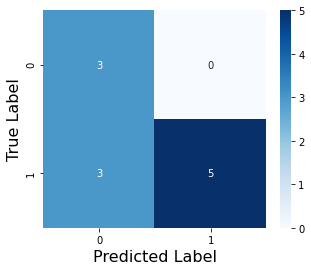

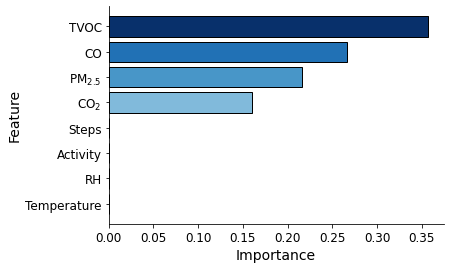

BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.833
		0.833
		0.833
		0.25
		0.167
	Average:	0.583
	Model Score: 0.864
Evaluating...


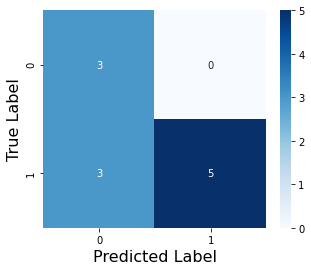

'BernoulliNB' object has no attribute 'feature_importances_'
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.833
		0.25
		0.833
		0.25
		0.5
	Average:	0.533
	Model Score: 0.864
Evaluating...


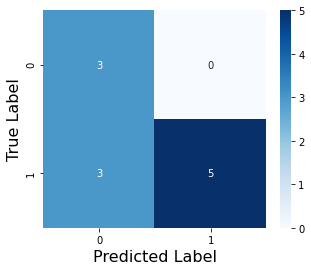

'KNeighborsClassifier' object has no attribute 'feature_importances_'
Getting Features and Target (rem_percent)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.108695
		Best Score:	0.75
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:15.765592
		Best Score:	0.75
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.063148
		Best Score:	0.75
		Best Params:	{'alpha': 0.5}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.331498
		Best Score:	0.75
		Best Params:	{'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
	Best Scoring Model:
		Model:	Logistic Regression
		Score:	0.75
		Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.562
		0.562
		0.562
		0.562
		0.562
	Average:	0.562
	Model Score: 0.207
Evaluating...


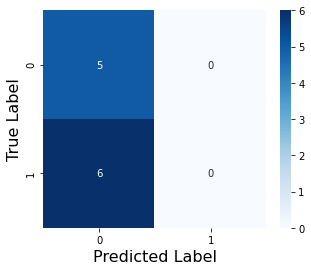

'LogisticRegression' object has no attribute 'feature_importances_'
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.562
		0.562
		0.562
		0.562
		0.562
	Average:	0.562
	Model Score: 0.207
Evaluating...


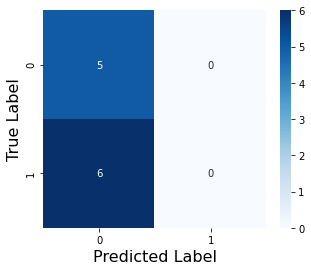

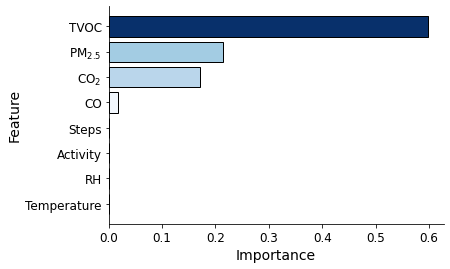

BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.562
		0.562
		0.562
		0.562
		0.562
	Average:	0.562
	Model Score: 0.207
Evaluating...


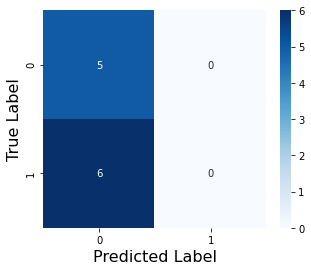

'BernoulliNB' object has no attribute 'feature_importances_'
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.562
		0.562
		0.562
		0.562
		0.562
	Average:	0.562
	Model Score: 0.207
Evaluating...


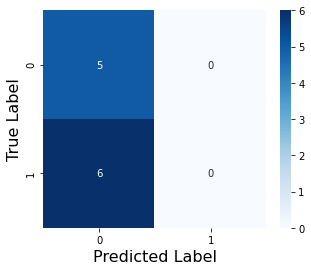

'KNeighborsClassifier' object has no attribute 'feature_importances_'
QH34M4R9
Getting Features and Target (se)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.114575
		Best Score:	0.9
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:15.812559
		Best Score:	0.9
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.062529
		Best Score:	0.9
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.331006
		Best Score:	0.9
		Best Params:	{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Logistic Regression
		Score:	0.9
		Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		1.0
		1.0
		0.694
		0.694
		0.694
	Average:	0.817
	Model Score: 0.871
Evaluating...


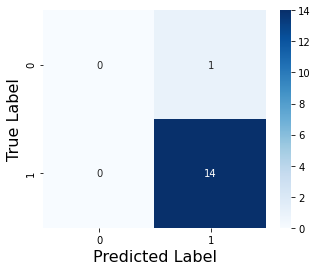

'LogisticRegression' object has no attribute 'feature_importances_'
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		1.0
		1.0
		0.694
		0.694
		0.694
	Average:	0.817
	Model Score: 0.871
Evaluating...


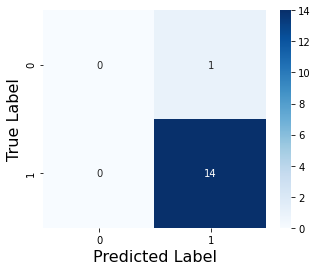

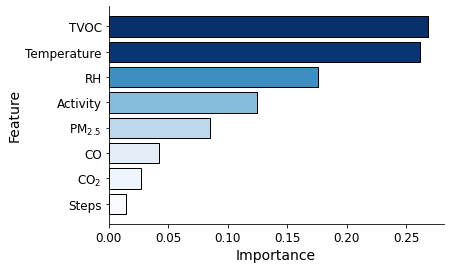

BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		1.0
		1.0
		0.694
		0.694
		0.694
	Average:	0.817
	Model Score: 0.867
Evaluating...


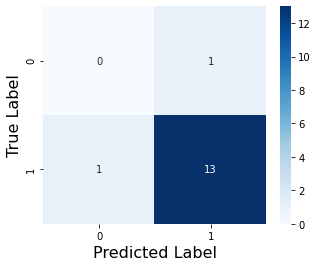

'BernoulliNB' object has no attribute 'feature_importances_'
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		1.0
		1.0
		0.694
		0.694
		0.694
	Average:	0.817
	Model Score: 0.871
Evaluating...


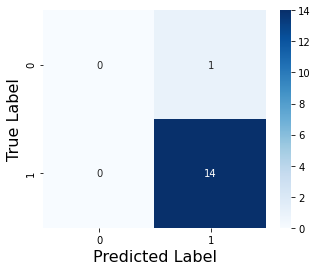

'KNeighborsClassifier' object has no attribute 'feature_importances_'
Getting Features and Target (tst)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.119295
		Best Score:	0.7666666666666666
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:15.863564
		Best Score:	0.8
		Best Params:	{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.062771
		Best Score:	0.7333333333333334
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.349107
		Best Score:	0.7666666666666666
		Best Params:	{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.8
		Params:	{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.694
		0.694
		0.694
		0.667
		0.867
	Average:	0.723
	Model

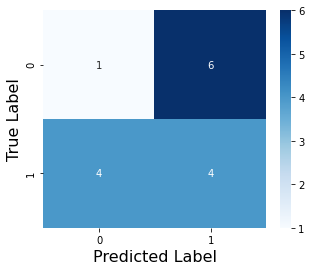

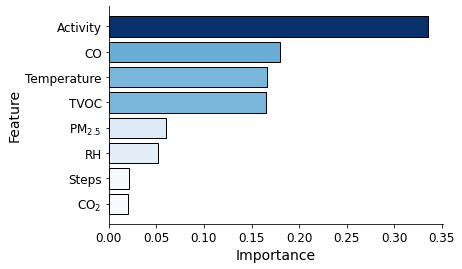

LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.694
		0.694
		0.694
		0.667
		0.444
	Average:	0.639
	Model Score: 0.284
Evaluating...


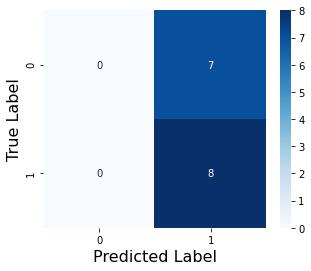

'LogisticRegression' object has no attribute 'feature_importances_'
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.694
		0.694
		0.694
		0.667
		0.444
	Average:	0.639
	Model Score: 0.521
Evaluating...


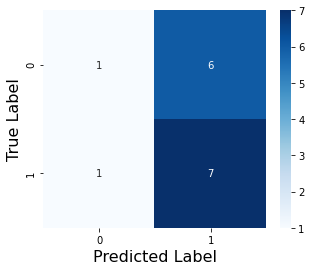

'KNeighborsClassifier' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.694
		0.694
		0.667
		0.625
		0.867
	Average:	0.709
	Model Score: 0.246
Evaluating...


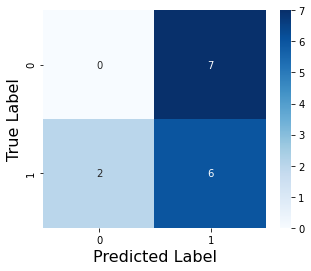

'BernoulliNB' object has no attribute 'feature_importances_'
Getting Features and Target (light_percent)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.117492
		Best Score:	0.5000000000000001
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:16.012933
		Best Score:	0.5666666666666667
		Best Params:	{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.063724
		Best Score:	0.5
		Best Params:	{'alpha': 1}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.350383
		Best Score:	0.5666666666666667
		Best Params:	{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.567
		Params:	{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.25
		0.4
		0.867
		0.333
		0.667
	Average:	0.503
	Mod

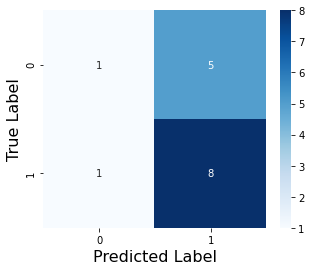

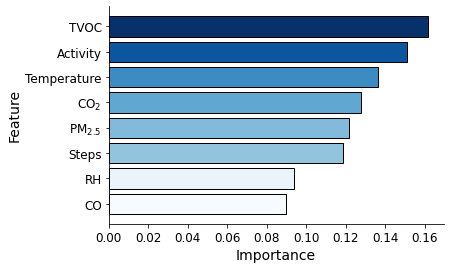

K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.8
		0.333
		0.867
		0.556
		0.8
	Average:	0.671
	Model Score: 0.582
Evaluating...


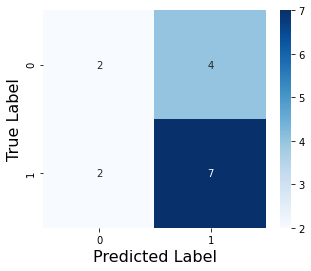

'KNeighborsClassifier' object has no attribute 'feature_importances_'
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.2
		0.867
		0.444
		0.333
		0.333
	Average:	0.436
	Model Score: 0.36
Evaluating...


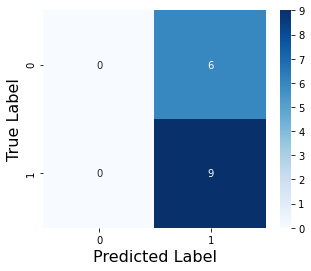

'LogisticRegression' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.2
		0.667
		0.444
		0.333
		0.4
	Average:	0.409
	Model Score: 0.483
Evaluating...


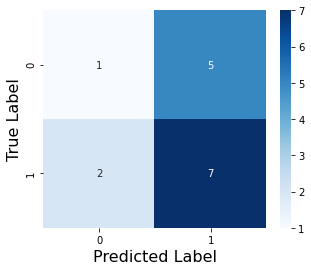

'BernoulliNB' object has no attribute 'feature_importances_'
Getting Features and Target (deep_percent)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.109666
		Best Score:	0.6666666666666666
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:15.959457
		Best Score:	0.8
		Best Params:	{'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 50}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.063132
		Best Score:	0.7333333333333334
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.330101
		Best Score:	0.7333333333333333
		Best Params:	{'n_neighbors': 7, 'p': 2, 'weights': 'distance'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.8
		Params:	{'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 50}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.694
		1.0
		0.867
		0.667
		0.444
	Average:	0.734
	Model 

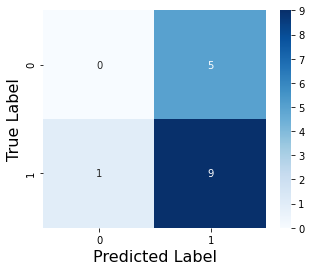

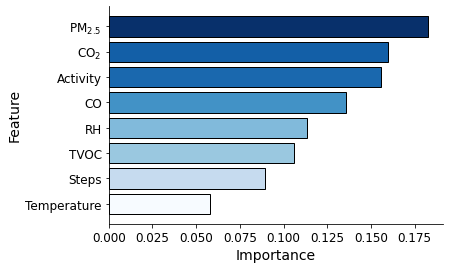

BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.694
		0.867
		0.444
		0.4
		0.867
	Average:	0.654
	Model Score: 0.652
Evaluating...


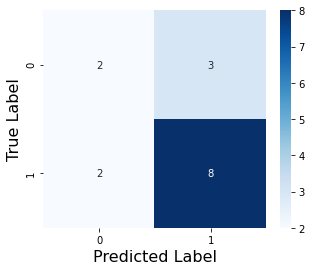

'BernoulliNB' object has no attribute 'feature_importances_'
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.667
		0.867
		0.867
		0.667
		0.444
	Average:	0.702
	Model Score: 0.6
Evaluating...


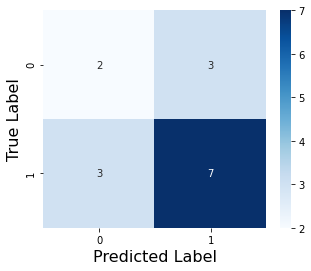

'KNeighborsClassifier' object has no attribute 'feature_importances_'
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.694
		0.444
		0.444
		0.4
		0.444
	Average:	0.486
	Model Score: 0.628
Evaluating...


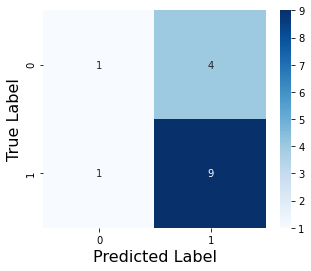

'LogisticRegression' object has no attribute 'feature_importances_'
Getting Features and Target (rem_percent)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.126876
		Best Score:	0.6000000000000001
		Best Params:	{'fit_intercept': False, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:16.075477
		Best Score:	0.7000000000000001
		Best Params:	{'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 100}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.063810
		Best Score:	0.6000000000000001
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.332279
		Best Score:	0.6666666666666667
		Best Params:	{'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.7
		Params:	{'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 100}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.8
		0.875
		0.875
		0.875
		0.333


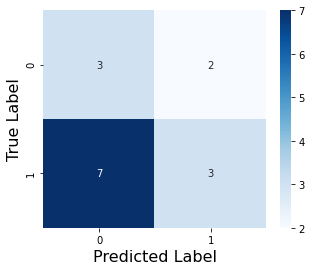

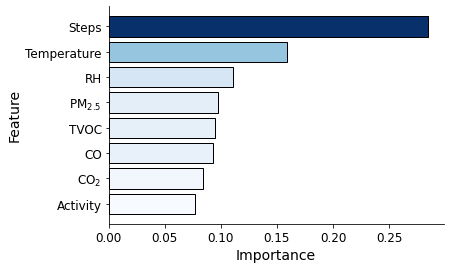

K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.25
		0.875
		0.875
		0.875
		0.333
	Average:	0.642
	Model Score: 0.424
Evaluating...


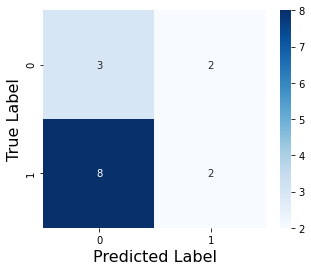

'KNeighborsClassifier' object has no attribute 'feature_importances_'
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.25
		0.25
		0.875
		0.875
		0.333
	Average:	0.517
	Model Score: 0.5
Evaluating...


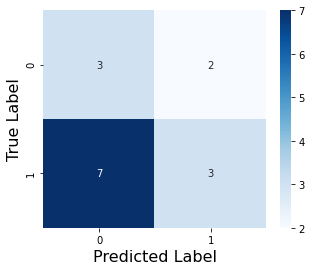

'LogisticRegression' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.25
		0.25
		0.875
		0.875
		0.333
	Average:	0.517
	Model Score: 0.5
Evaluating...


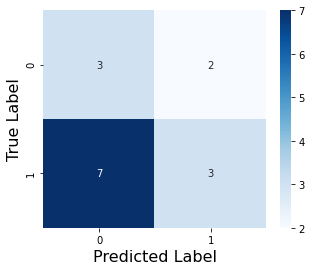

'BernoulliNB' object has no attribute 'feature_importances_'
LKKJDDAM
Getting Features and Target (se)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.108790
		Best Score:	0.5619047619047619
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:15.900110
		Best Score:	0.6285714285714286
		Best Params:	{'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 50}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.062468
		Best Score:	0.5333333333333333
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.333845
		Best Score:	0.5095238095238096
		Best Params:	{'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.629
		Params:	{'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 50}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.595
		0.457
		0.886
		0.229
		1.0
	Averag

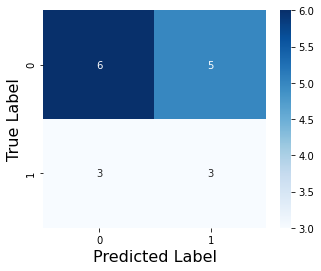

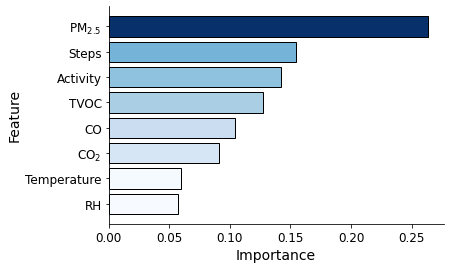

LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.81
		0.595
		0.595
		0.229
		0.8
	Average:	0.606
	Model Score: 0.68
Evaluating...


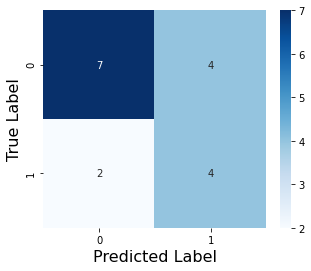

'LogisticRegression' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.81
		0.229
		0.595
		0.429
		0.8
	Average:	0.572
	Model Score: 0.489
Evaluating...


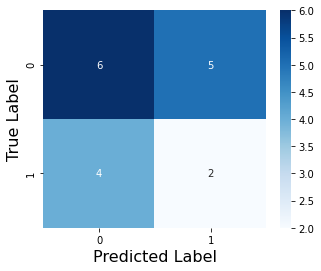

'BernoulliNB' object has no attribute 'feature_importances_'
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.595
		0.457
		0.457
		0.229
		0.875
	Average:	0.523
	Model Score: 0.448
Evaluating...


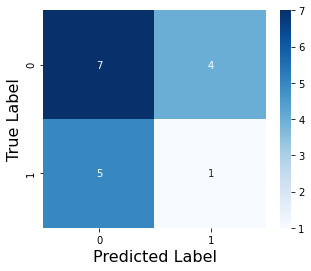

'KNeighborsClassifier' object has no attribute 'feature_importances_'
Getting Features and Target (tst)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.115866
		Best Score:	0.7666666666666667
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:15.905603
		Best Score:	0.7666666666666667
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.065011
		Best Score:	0.6714285714285715
		Best Params:	{'alpha': 1}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.335285
		Best Score:	0.7952380952380953
		Best Params:	{'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	K-Nearest Neighbor
		Score:	0.795
		Params:	{'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.735
		0.735
		0.51
		0.51
		0.694
	Average:	0.637
	Model Score: 0.

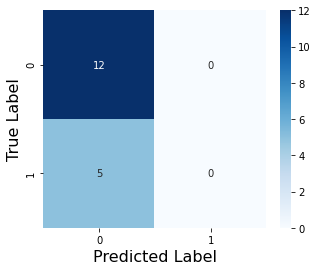

'KNeighborsClassifier' object has no attribute 'feature_importances_'
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.735
		0.714
		0.51
		0.51
		0.694
	Average:	0.633
	Model Score: 0.498
Evaluating...


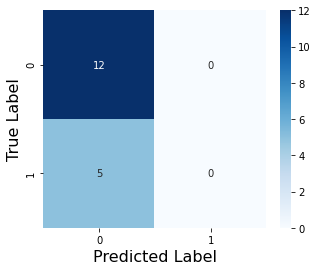

'LogisticRegression' object has no attribute 'feature_importances_'
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.735
		0.714
		0.51
		0.51
		0.694
	Average:	0.633
	Model Score: 0.498
Evaluating...


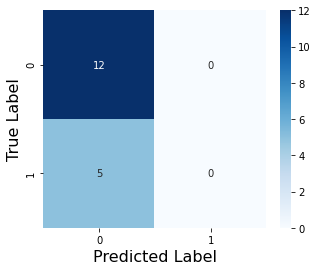

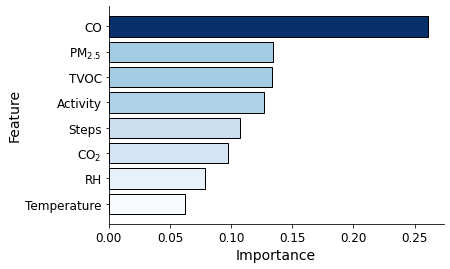

BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.735
		0.714
		0.476
		0.51
		0.625
	Average:	0.612
	Model Score: 0.498
Evaluating...


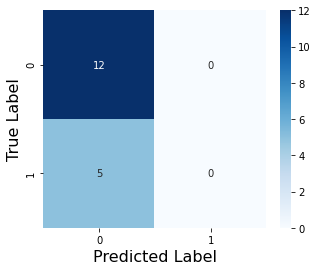

'BernoulliNB' object has no attribute 'feature_importances_'
Getting Features and Target (light_percent)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.120033
		Best Score:	0.4714285714285714
		Best Params:	{'fit_intercept': False, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:17.659829
		Best Score:	0.5285714285714286
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.064270
		Best Score:	0.5285714285714286
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.350865
		Best Score:	0.5
		Best Params:	{'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.529
		Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.327
		0.557
		0.327
		0.286
		0.4
	Average:	0.379
	M

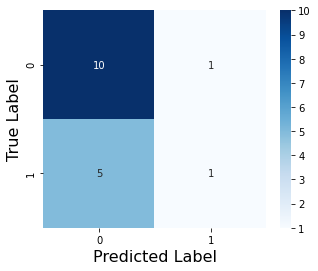

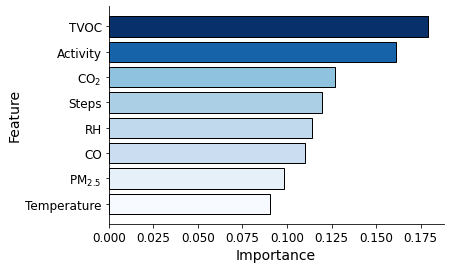

BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.286
		0.457
		0.429
		0.886
		0.4
	Average:	0.491
	Model Score: 0.608
Evaluating...


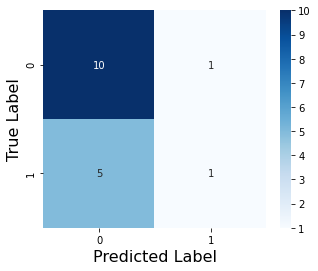

'BernoulliNB' object has no attribute 'feature_importances_'
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.286
		0.429
		0.557
		0.327
		0.4
	Average:	0.4
	Model Score: 0.608
Evaluating...


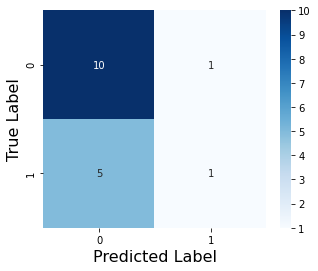

'KNeighborsClassifier' object has no attribute 'feature_importances_'
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.327
		0.557
		0.429
		0.229
		0.4
	Average:	0.388
	Model Score: 0.608
Evaluating...


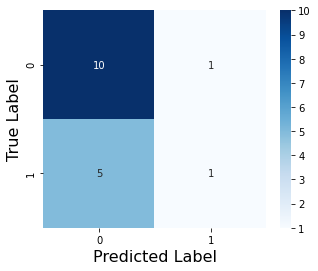

'LogisticRegression' object has no attribute 'feature_importances_'
Getting Features and Target (deep_percent)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.121391
		Best Score:	0.4904761904761904
		Best Params:	{'fit_intercept': False, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:15.955566
		Best Score:	0.619047619047619
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.065902
		Best Score:	0.619047619047619
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.334866
		Best Score:	0.5285714285714286
		Best Params:	{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.619
		Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.886
		0.457
		0.286
		0.714
		0.667

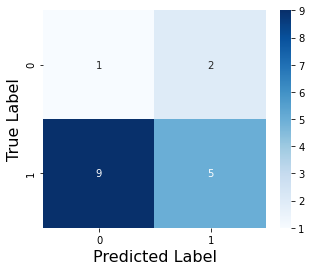

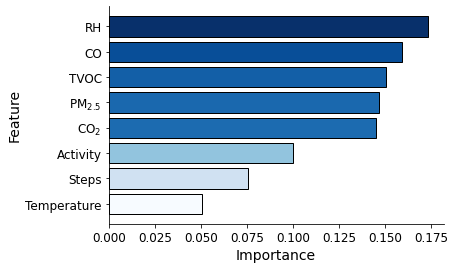

BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.886
		0.457
		0.286
		0.714
		0.833
	Average:	0.635
	Model Score: 0.606
Evaluating...


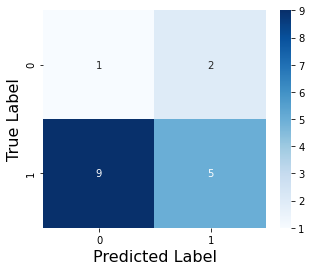

'BernoulliNB' object has no attribute 'feature_importances_'
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.595
		0.595
		0.286
		0.595
		0.8
	Average:	0.574
	Model Score: 0.606
Evaluating...


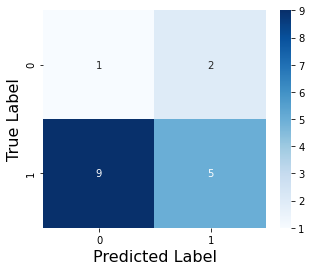

'KNeighborsClassifier' object has no attribute 'feature_importances_'
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.81
		0.595
		0.286
		0.557
		0.222
	Average:	0.494
	Model Score: 0.663
Evaluating...


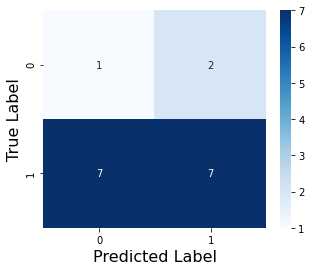

'LogisticRegression' object has no attribute 'feature_importances_'
Getting Features and Target (rem_percent)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.118583
		Best Score:	0.5857142857142856
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:16.028962
		Best Score:	0.680952380952381
		Best Params:	{'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.062981
		Best Score:	0.4666666666666666
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.333232
		Best Score:	0.6761904761904762
		Best Params:	{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.681
		Params:	{'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.595
		0.893
		0.457
		0.714
		0.875


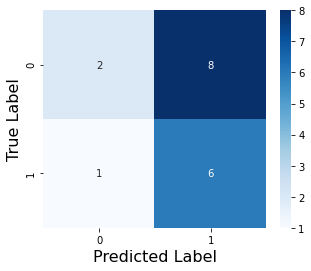

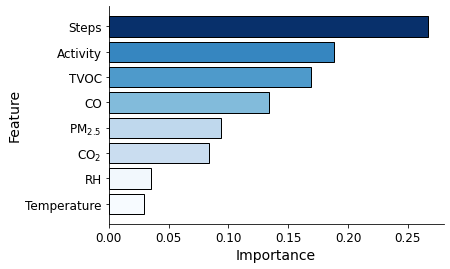

K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.595
		1.0
		0.457
		0.714
		0.667
	Average:	0.687
	Model Score: 0.459
Evaluating...


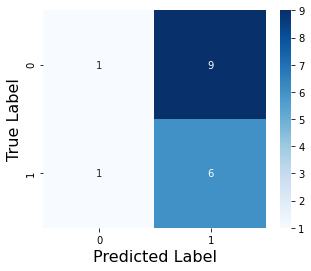

'KNeighborsClassifier' object has no attribute 'feature_importances_'
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.595
		0.886
		0.143
		0.81
		0.5
	Average:	0.587
	Model Score: 0.452
Evaluating...


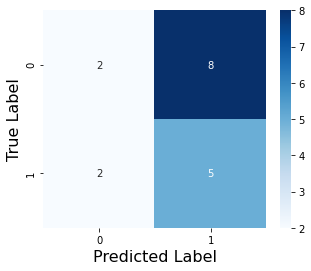

'LogisticRegression' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.595
		0.595
		0.143
		0.557
		0.2
	Average:	0.418
	Model Score: 0.444
Evaluating...


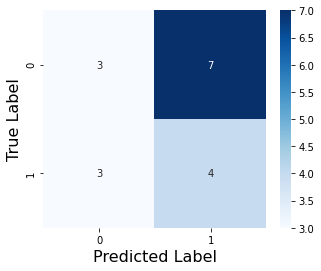

'BernoulliNB' object has no attribute 'feature_importances_'
VR9J5RRY
Getting Features and Target (se)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.107027
		Best Score:	nan
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:15.905812
		Best Score:	0.96
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.063543
		Best Score:	0.96
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.332529
		Best Score:	0.96
		Best Params:	{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.96
		Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.64
		1.0
		1.0
		1.0
		1.0
	Average:	0.928
	Model Score: 1.0
Evaluating...


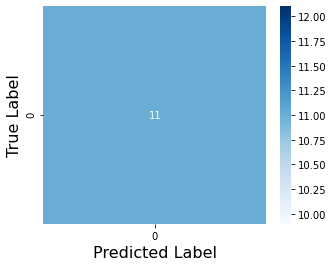

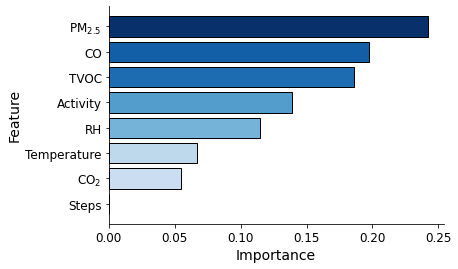

BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.64
		1.0
		1.0
		1.0
		1.0
	Average:	0.928
	Model Score: 1.0
Evaluating...


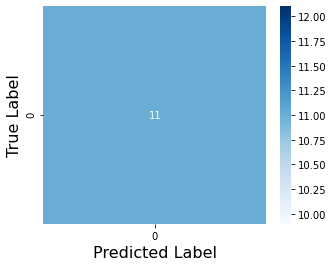

'BernoulliNB' object has no attribute 'feature_importances_'
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.64
		1.0
		1.0
		1.0
		1.0
	Average:	0.928
	Model Score: 1.0
Evaluating...


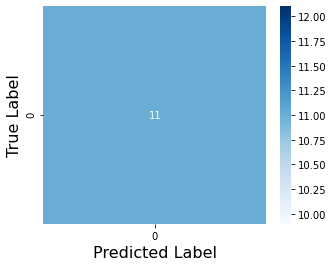

'KNeighborsClassifier' object has no attribute 'feature_importances_'
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		nan
		1.0
		1.0
		1.0
		1.0
	Average:	nan
	Model Score: 1.0
Evaluating...


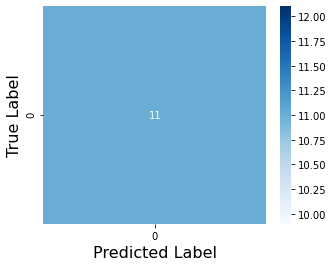

'LogisticRegression' object has no attribute 'feature_importances_'
Getting Features and Target (tst)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.112842
		Best Score:	0.42000000000000004
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:15.927990
		Best Score:	0.42000000000000004
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.063930
		Best Score:	0.38
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.336659
		Best Score:	0.37
		Best Params:	{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Logistic Regression
		Score:	0.42
		Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.36
		0.833
		0.25
		0.0
		0.25
	Average:	0.339
	Model Score: 0.455
Evaluating...


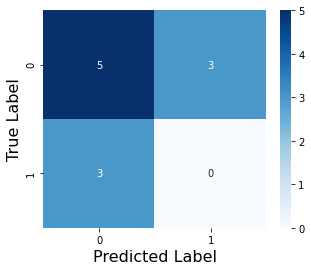

'LogisticRegression' object has no attribute 'feature_importances_'
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.36
		0.833
		0.25
		0.0
		0.25
	Average:	0.339
	Model Score: 0.416
Evaluating...


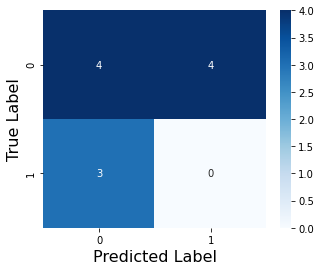

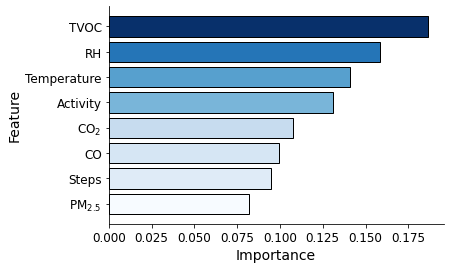

BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.3
		0.833
		0.25
		0.0
		0.25
	Average:	0.327
	Model Score: 0.539
Evaluating...


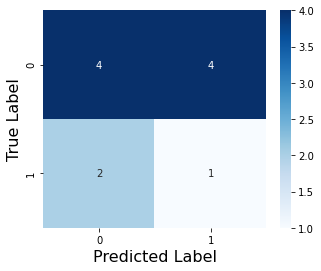

'BernoulliNB' object has no attribute 'feature_importances_'
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.36
		0.375
		0.25
		0.0
		0.25
	Average:	0.247
	Model Score: 0.588
Evaluating...


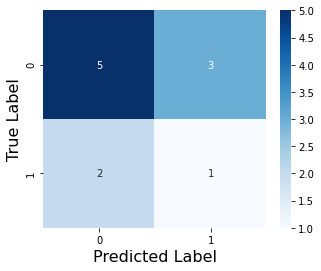

'KNeighborsClassifier' object has no attribute 'feature_importances_'
Getting Features and Target (light_percent)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.118683
		Best Score:	0.76
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:15.935128
		Best Score:	0.76
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.063996
		Best Score:	0.67
		Best Params:	{'alpha': 1}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.333105
		Best Score:	0.76
		Best Params:	{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Logistic Regression
		Score:	0.76
		Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.64
		0.562
		0.562
		0.562
		0.562
	Average:	0.578
	Model Score: 0.529
Evaluating...


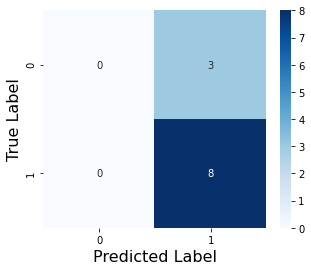

'LogisticRegression' object has no attribute 'feature_importances_'
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.64
		0.562
		0.562
		0.562
		0.562
	Average:	0.578
	Model Score: 0.529
Evaluating...


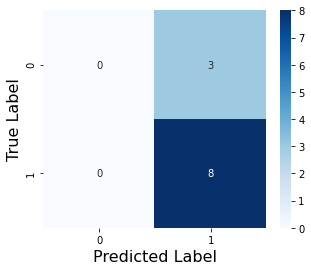

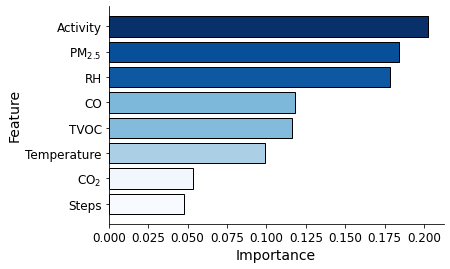

K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.64
		0.562
		0.562
		0.562
		0.562
	Average:	0.578
	Model Score: 0.509
Evaluating...


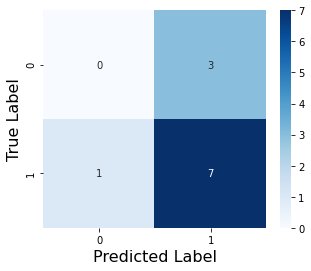

'KNeighborsClassifier' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.6
		0.562
		0.5
		0.562
		0.562
	Average:	0.558
	Model Score: 0.855
Evaluating...


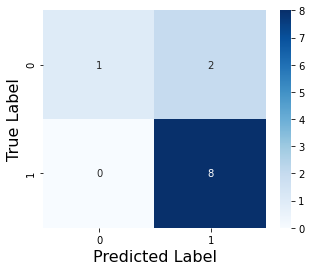

'BernoulliNB' object has no attribute 'feature_importances_'
Getting Features and Target (deep_percent)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.117242
		Best Score:	0.15
		Best Params:	{'fit_intercept': False, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:15.931145
		Best Score:	0.39
		Best Params:	{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.063311
		Best Score:	0.1
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.333016
		Best Score:	0.45
		Best Params:	{'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	K-Nearest Neighbor
		Score:	0.45
		Params:	{'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.0
		0.25
		1.0
		0.167
		0.5
	Average:	0.383
	Model Score: 0.303
Evaluating...


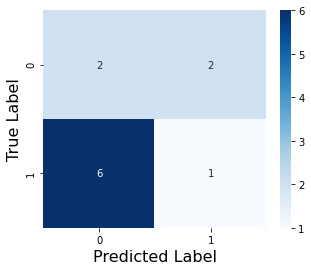

'KNeighborsClassifier' object has no attribute 'feature_importances_'
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.2
		0.833
		0.833
		0.167
		0.0
	Average:	0.407
	Model Score: 0.422
Evaluating...


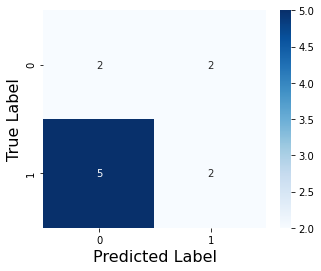

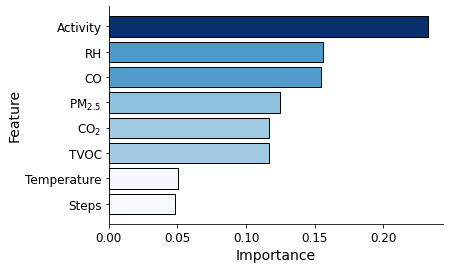

LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.0
		0.0
		0.5
		0.0
		0.167
	Average:	0.133
	Model Score: 0.315
Evaluating...


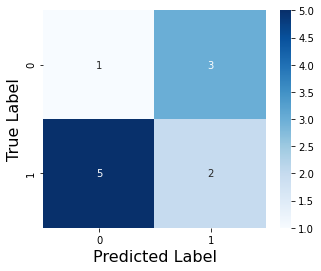

'LogisticRegression' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.0
		0.0
		0.167
		0.167
		0.0
	Average:	0.067
	Model Score: 0.273
Evaluating...


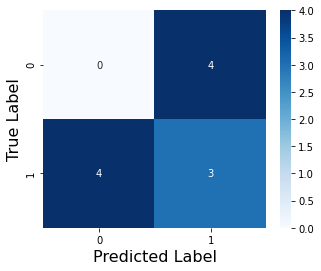

'BernoulliNB' object has no attribute 'feature_importances_'
Getting Features and Target (rem_percent)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.124662
		Best Score:	0.5599999999999999
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:15.999858
		Best Score:	0.8
		Best Params:	{'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.063186
		Best Score:	0.45999999999999996
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.330036
		Best Score:	0.75
		Best Params:	{'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.8
		Params:	{'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		1.0
		0.875
		0.875
		0.833
		0.833
	Average:	0.883
	Model Score: 0.685
E

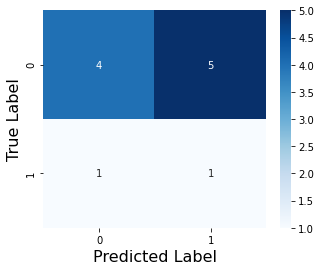

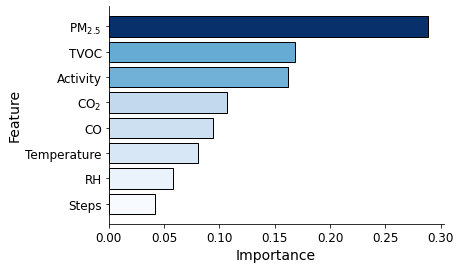

K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		1.0
		0.875
		0.5
		0.833
		0.833
	Average:	0.808
	Model Score: 0.685
Evaluating...


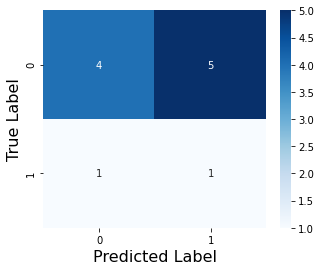

'KNeighborsClassifier' object has no attribute 'feature_importances_'
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.85
		0.875
		0.5
		0.167
		0.25
	Average:	0.528
	Model Score: 0.614
Evaluating...


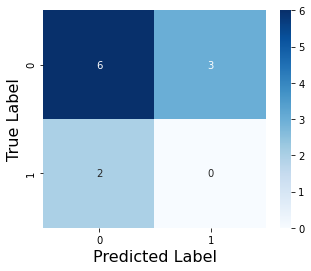

'LogisticRegression' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.85
		0.875
		0.375
		0.167
		0.167
	Average:	0.487
	Model Score: 0.614
Evaluating...


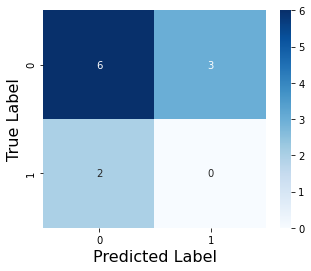

'BernoulliNB' object has no attribute 'feature_importances_'
AWA8UCES
Getting Features and Target (se)...
Splitting Data...
Testing Classifiers...
	Logistic Regression


ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 1

In [122]:
ind_pred = ieq_and_sq_prediction()
ind_res = {"beiwe":[],"n":[],"target":[],"best_performing_model":[],"model_score":[],"biased_score":[],"sensitive_parameter1":[],"sensitive_parameter2":[]}
for pt in ieq_and_activity_gt30["beiwe"].unique():
    print(pt.upper())
    fts = ieq_and_activity_gt30[ieq_and_activity_gt30["beiwe"] == pt]
    tgts = fbsq[fbsq["beiwe"] == pt]
    for fb_target in ["se","tst","light_percent","deep_percent","rem_percent"]:
        if len(tgts[f"{fb_target}_binary"].unique()) > 1:
            ind_pred.run(fts,tgts,fb_target)
            # adding results
            ind_res["beiwe"].append(pt)
            ind_res["n"].append(len(ind_pred.features))
            ind_res["target"].append(fb_target)
            ind_res["best_performing_model"].append(ind_pred.results.iloc[0,0])
            ind_res["model_score"].append(ind_pred.results.iloc[0,1])
            bs = sum(ind_pred.targets.values)/len(ind_pred.targets)
            res["biased_score"].append(bs[0] if bs[0] > 0.5 else 1-bs[0])
            try:
                ind_res["sensitive_parameter1"].append(ind_pred.feature_importance.sort_values("importance",ascending=False).iloc[0,0])
                ind_res["sensitive_parameter2"].append(ind_pred.feature_importance.sort_values("importance",ascending=False).iloc[1,0])
            except KeyError:
                ind_res["sensitive_parameter1"].append(np.nan)
                ind_res["sensitive_parameter2"].append(np.nan)
        else:
            print("Only 1 unique value for", fb_target.replace("_"," "))

In [ ]:
ind_results = pd.DataFrame(res)

#### Summary and Analysis
Now that we have run the classification model on all the participants, we can take a look at the results to see if there are any similarities amongst the participants.

### Predicting other Participant Sleep Quality
We can also create a scheme where we predict the sleep quality of a few participants by training on a larger subset of the participants. 

We have two tools for model selection:
1. GroupKFold: Here we specify a certain number of splits to be made and a leave a subset of participants out of the training set to use as the test set. 
2. LeaveOneGroupOut: This cross-validation goes as far as to include all but one participant in the training set. Then we try to predict the sleep quality of that left-out individual.

Getting Features and Target (se)...
SPLIT 1
	Train:	381
	Test:	127

Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.145660
		Best Score:	0.8136705399863295
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:16.587585
		Best Score:	0.8136705399863295
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.063807
		Best Score:	0.8136705399863295
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.402437
		Best Score:	0.7664388243335611
		Best Params:	{'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Logistic Regression
		Score:	0.814
		Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.648
		0.666
		0.666
		0.666
		0.666
	Average:	0.662
	Model Score: 0.56
Evaluating...


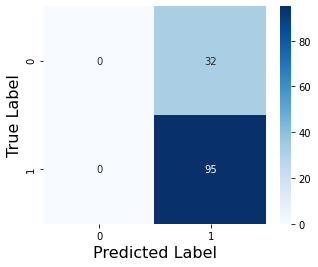

'LogisticRegression' object has no attribute 'feature_importances_'
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.648
		0.666
		0.666
		0.666
		0.666
	Average:	0.662
	Model Score: 0.56
Evaluating...


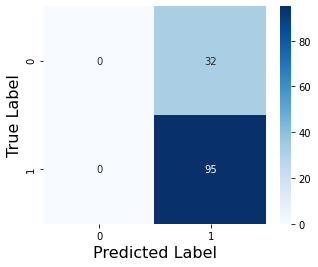

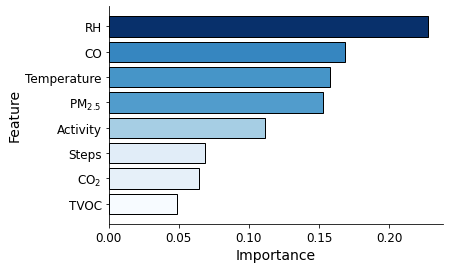

BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.648
		0.666
		0.666
		0.666
		0.666
	Average:	0.662
	Model Score: 0.56
Evaluating...


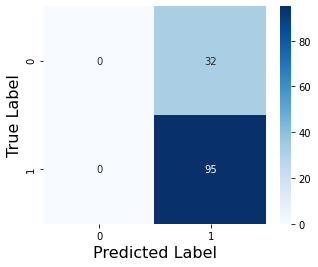

'BernoulliNB' object has no attribute 'feature_importances_'
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.702
		0.659
		0.648
		0.732
		0.715
	Average:	0.691
	Model Score: 0.6
Evaluating...


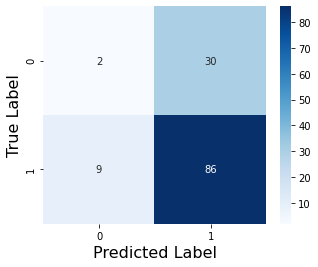

'KNeighborsClassifier' object has no attribute 'feature_importances_'
SPLIT 1
	Train:	381
	Test:	127

Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.126057
		Best Score:	0.7979152426520848
		Best Params:	{'fit_intercept': True, 'solver': 'liblinear'}
	Random Forest
		Elapsed Time:	 0:00:16.898762
		Best Score:	0.7979152426520848
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.064317
		Best Score:	0.7742652084757349
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.398711
		Best Score:	0.740088858509911
		Best Params:	{'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Logistic Regression
		Score:	0.798
		Params:	{'fit_intercept': True, 'solver': 'liblinear'}
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.738
		0.644
		0.644
		0.644
		0.623
	Average:	0.659
	Model Score: 0.632
Evaluating...


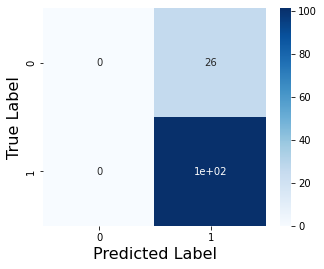

'LogisticRegression' object has no attribute 'feature_importances_'
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.628
		0.644
		0.644
		0.644
		0.623
	Average:	0.637
	Model Score: 0.632
Evaluating...


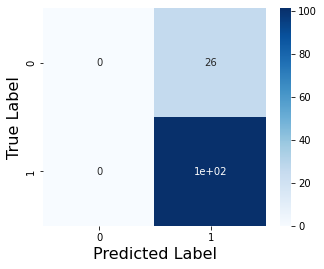

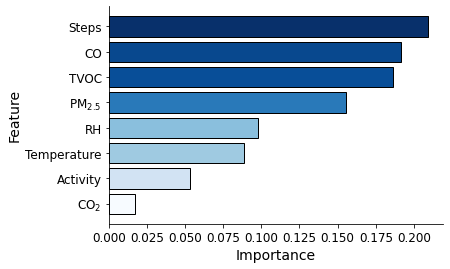

BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.701
		0.64
		0.64
		0.644
		0.655
	Average:	0.656
	Model Score: 0.632
Evaluating...


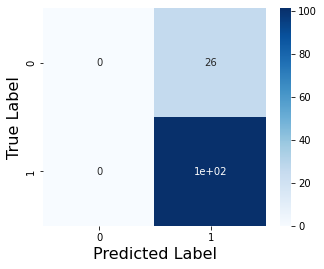

'BernoulliNB' object has no attribute 'feature_importances_'
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.721
		0.696
		0.632
		0.791
		0.642
	Average:	0.696
	Model Score: 0.677
Evaluating...


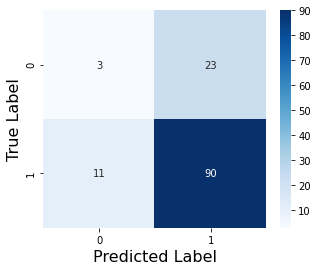

'KNeighborsClassifier' object has no attribute 'feature_importances_'
SPLIT 1
	Train:	380
	Test:	128

Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.122979
		Best Score:	0.8184210526315789
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:18.545846
		Best Score:	0.8184210526315789
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.063593
		Best Score:	0.8184210526315789
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.403627
		Best Score:	0.7947368421052632
		Best Params:	{'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Logistic Regression
		Score:	0.818
		Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.687
		0.666
		0.666
		0.666
		0.666
	Average:	0.67
	Model Score: 0.539
Evaluating...


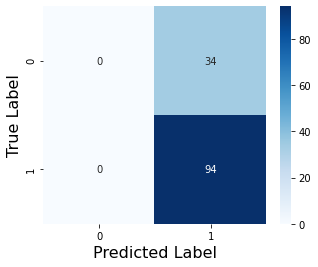

'LogisticRegression' object has no attribute 'feature_importances_'
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.687
		0.666
		0.666
		0.666
		0.666
	Average:	0.67
	Model Score: 0.539
Evaluating...


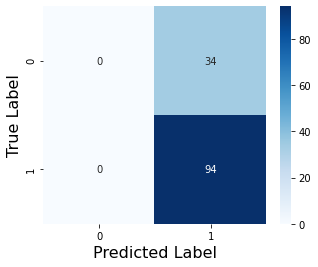

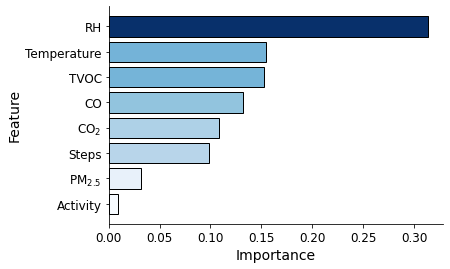

BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.687
		0.666
		0.666
		0.666
		0.666
	Average:	0.67
	Model Score: 0.539
Evaluating...


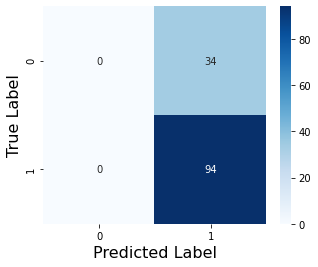

'BernoulliNB' object has no attribute 'feature_importances_'
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.715
		0.695
		0.715
		0.666
		0.859
	Average:	0.73
	Model Score: 0.535
Evaluating...


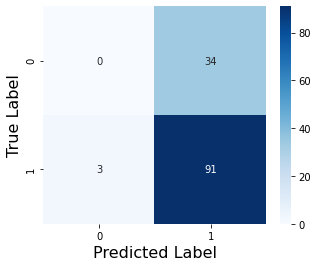

'KNeighborsClassifier' object has no attribute 'feature_importances_'
SPLIT 1
	Train:	382
	Test:	126

Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.124263
		Best Score:	0.7539986329460013
		Best Params:	{'fit_intercept': True, 'solver': 'liblinear'}
	Random Forest
		Elapsed Time:	 0:00:16.546101
		Best Score:	0.7591934381408065
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.063858
		Best Score:	0.7199248120300752
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.410943
		Best Score:	0.6987354750512645
		Best Params:	{'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.759
		Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.567
		0.567
		0.582
		0.582
		0.582
	Average:	0.576
	Model S

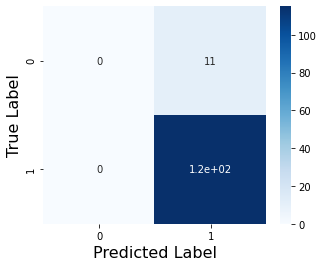

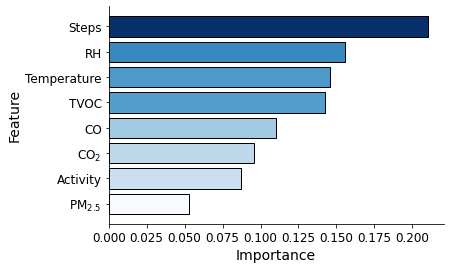

LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.629
		0.696
		0.582
		0.582
		0.582
	Average:	0.614
	Model Score: 0.855
Evaluating...


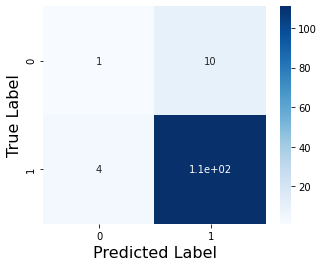

'LogisticRegression' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.62
		0.565
		0.636
		0.58
		0.686
	Average:	0.617
	Model Score: 0.846
Evaluating...


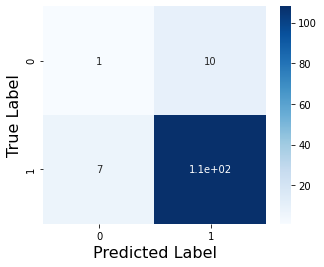

'BernoulliNB' object has no attribute 'feature_importances_'
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.674
		0.697
		0.595
		0.617
		0.672
	Average:	0.651
	Model Score: 0.827
Evaluating...


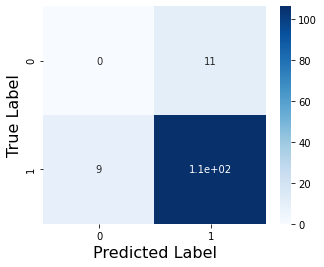

'KNeighborsClassifier' object has no attribute 'feature_importances_'
Getting Features and Target (tst)...
SPLIT 2
	Train:	381
	Test:	127

Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.120853
		Best Score:	0.5799384825700615
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:16.499776
		Best Score:	0.6115516062884483
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.063972
		Best Score:	0.5483595352016405
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.398595
		Best Score:	0.569583048530417
		Best Params:	{'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.612
		Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.373
		0.366
		0.366
		0.382


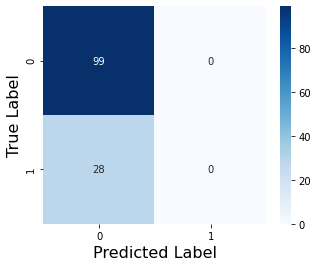

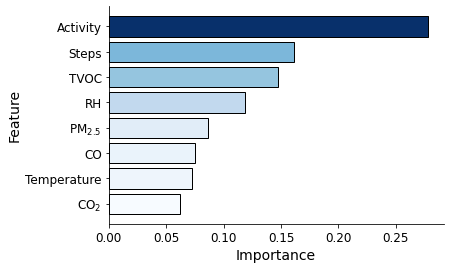

LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.615
		0.511
		0.416
		0.546
		0.593
	Average:	0.536
	Model Score: 0.604
Evaluating...


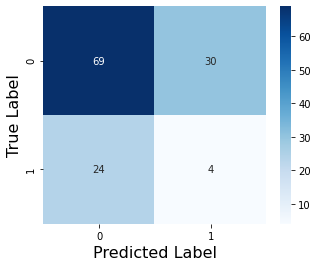

'LogisticRegression' object has no attribute 'feature_importances_'
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.46
		0.666
		0.48
		0.469
		0.619
	Average:	0.539
	Model Score: 0.675
Evaluating...


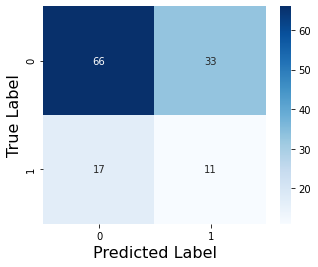

'KNeighborsClassifier' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.615
		0.567
		0.421
		0.507
		0.469
	Average:	0.516
	Model Score: 0.628
Evaluating...


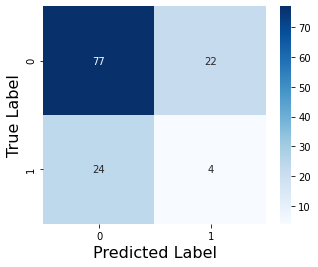

'BernoulliNB' object has no attribute 'feature_importances_'
SPLIT 2
	Train:	381
	Test:	127

Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.120072
		Best Score:	0.6061859193438142
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:16.641741
		Best Score:	0.6482911825017089
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.064780
		Best Score:	0.6272385509227615
		Best Params:	{'alpha': 1}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.399735
		Best Score:	0.5485304169514695
		Best Params:	{'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.648
		Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.422
		0.416
		0.416
		0.416
		0.433
	Average:	0.42
	Model Score: 0.448
E

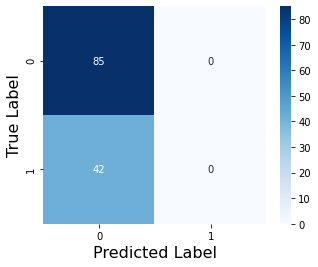

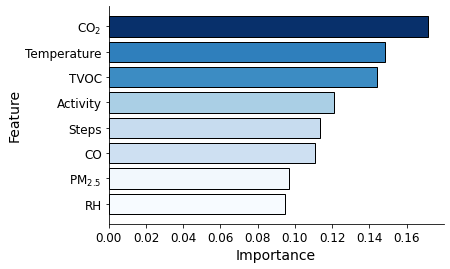

BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.422
		0.416
		0.776
		0.416
		0.403
	Average:	0.486
	Model Score: 0.448
Evaluating...


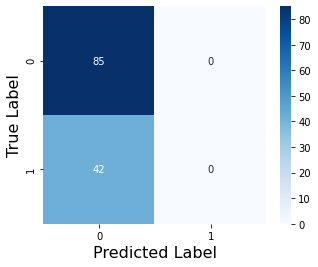

'BernoulliNB' object has no attribute 'feature_importances_'
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.422
		0.504
		0.776
		0.4
		0.41
	Average:	0.502
	Model Score: 0.448
Evaluating...


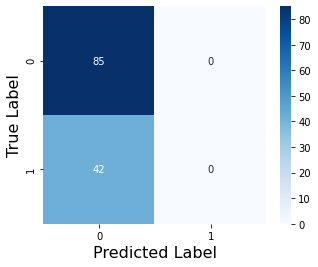

'LogisticRegression' object has no attribute 'feature_importances_'
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.502
		0.611
		0.465
		0.482
		0.477
	Average:	0.507
	Model Score: 0.603
Evaluating...


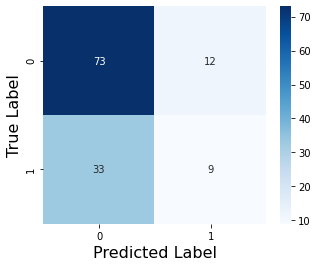

'KNeighborsClassifier' object has no attribute 'feature_importances_'
SPLIT 2
	Train:	380
	Test:	128

Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.113768
		Best Score:	0.6105263157894738
		Best Params:	{'fit_intercept': True, 'solver': 'liblinear'}
	Random Forest
		Elapsed Time:	 0:00:16.456101
		Best Score:	0.6578947368421053
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.063195
		Best Score:	0.6157894736842107
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.400002
		Best Score:	0.5947368421052632
		Best Params:	{'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.658
		Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.433
		0.433
		0.433
		0.433
		0.433
	Average:	0.433
	Model 

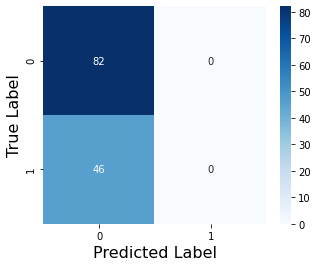

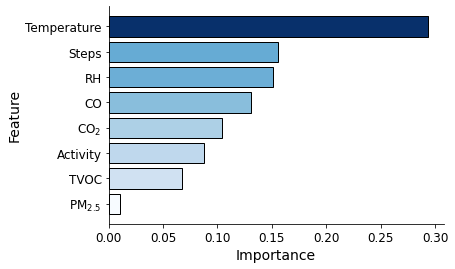

BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.433
		0.43
		0.433
		0.459
		0.436
	Average:	0.438
	Model Score: 0.41
Evaluating...


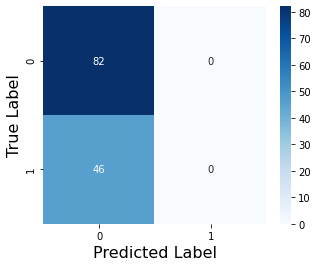

'BernoulliNB' object has no attribute 'feature_importances_'
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.43
		0.433
		0.572
		0.46
		0.41
	Average:	0.461
	Model Score: 0.773
Evaluating...


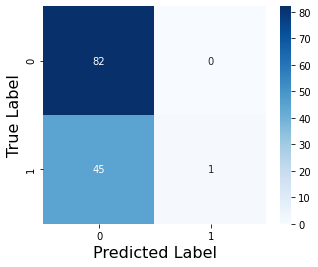

'LogisticRegression' object has no attribute 'feature_importances_'
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.511
		0.599
		0.526
		0.476
		0.65
	Average:	0.552
	Model Score: 0.55
Evaluating...


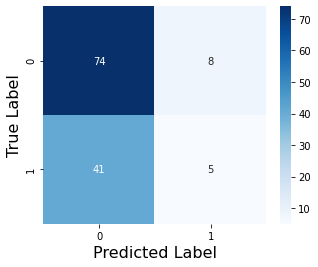

'KNeighborsClassifier' object has no attribute 'feature_importances_'
SPLIT 2
	Train:	382
	Test:	126

Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.118140
		Best Score:	0.667805878332194
		Best Params:	{'fit_intercept': False, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:17.639399
		Best Score:	0.7015721120984278
		Best Params:	{'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.064567
		Best Score:	0.6700273410799726
		Best Params:	{'alpha': 1}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.403231
		Best Score:	0.6233082706766917
		Best Params:	{'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.702
		Params:	{'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.649
		0.701
		0.802
		0.484
		0.486
	Average:	0.624
	Model Score

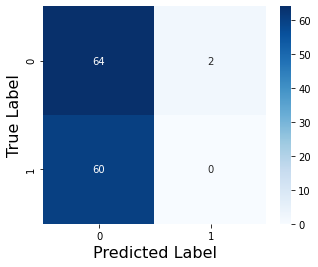

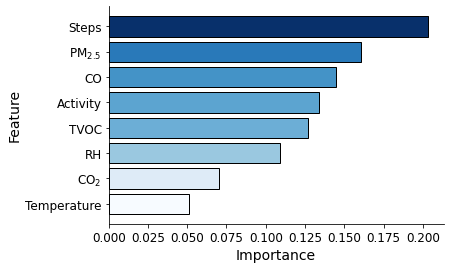

BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.474
		0.653
		0.536
		0.486
		0.486
	Average:	0.527
	Model Score: 0.27
Evaluating...


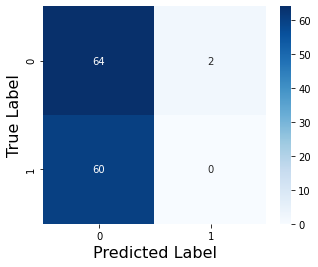

'BernoulliNB' object has no attribute 'feature_importances_'
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.581
		0.551
		0.641
		0.795
		0.486
	Average:	0.611
	Model Score: 0.264
Evaluating...


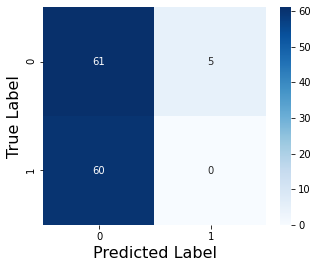

'LogisticRegression' object has no attribute 'feature_importances_'
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.611
		0.497
		0.57
		0.529
		0.678
	Average:	0.577
	Model Score: 0.5
Evaluating...


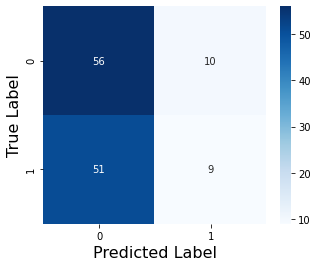

'KNeighborsClassifier' object has no attribute 'feature_importances_'
Getting Features and Target (light_percent)...
SPLIT 3
	Train:	381
	Test:	127

Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.120947
		Best Score:	0.48294600136705396
		Best Params:	{'fit_intercept': False, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:16.596946
		Best Score:	0.4383116883116883
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.064458
		Best Score:	0.409501025290499
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.397453
		Best Score:	0.4645933014354068
		Best Params:	{'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Logistic Regression
		Score:	0.483
		Params:	{'fit_intercept': False, 'solver': 'lbfgs'}
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.481
		0.513
		0.473
		0.429
		0.511
	Average

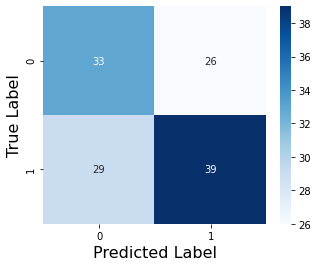

'LogisticRegression' object has no attribute 'feature_importances_'
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.455
		0.394
		0.514
		0.404
		0.56
	Average:	0.466
	Model Score: 0.538
Evaluating...


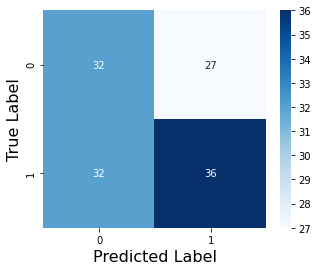

'KNeighborsClassifier' object has no attribute 'feature_importances_'
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.441
		0.379
		0.526
		0.329
		0.511
	Average:	0.438
	Model Score: 0.539
Evaluating...


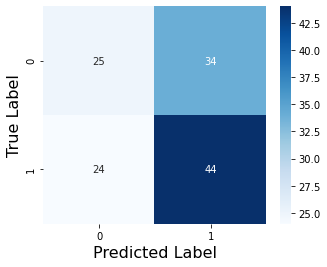

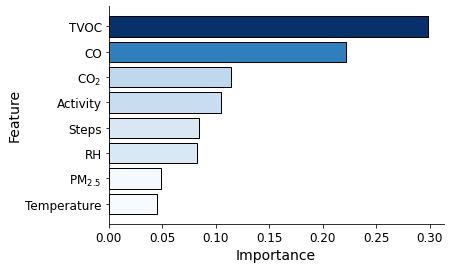

BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.39
		0.434
		0.457
		0.284
		0.475
	Average:	0.408
	Model Score: 0.519
Evaluating...


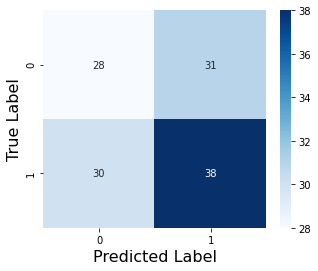

'BernoulliNB' object has no attribute 'feature_importances_'
SPLIT 3
	Train:	381
	Test:	127

Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.125702
		Best Score:	0.46421736158578264
		Best Params:	{'fit_intercept': False, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:16.401976
		Best Score:	0.4907382091592617
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.064067
		Best Score:	0.46971975393028026
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.398322
		Best Score:	0.4828434723171566
		Best Params:	{'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.491
		Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.515
		0.554
		0.452
		0.363
		0.519
	Average:	0.481
	Model Score: 0.28

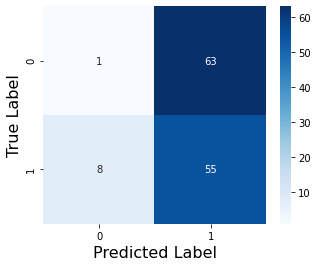

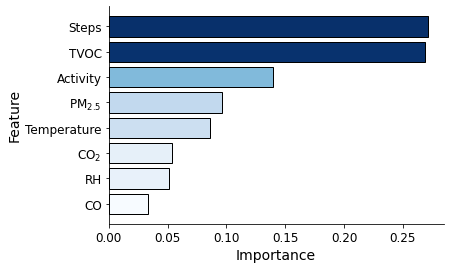

K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.534
		0.489
		0.526
		0.444
		0.438
	Average:	0.486
	Model Score: 0.512
Evaluating...


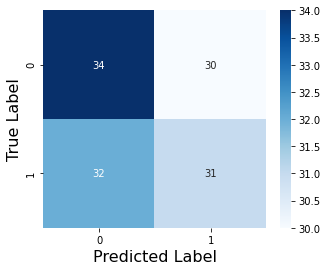

'KNeighborsClassifier' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.506
		0.475
		0.459
		0.47
		0.426
	Average:	0.467
	Model Score: 0.332
Evaluating...


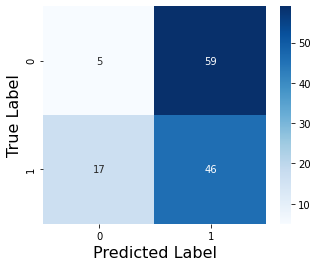

'BernoulliNB' object has no attribute 'feature_importances_'
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.621
		0.408
		0.499
		0.344
		0.466
	Average:	0.468
	Model Score: 0.551
Evaluating...


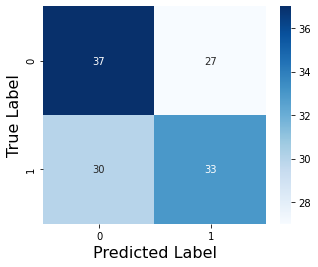

'LogisticRegression' object has no attribute 'feature_importances_'
SPLIT 3
	Train:	380
	Test:	128

Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.121434
		Best Score:	0.4947368421052631
		Best Params:	{'fit_intercept': False, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:16.615091
		Best Score:	0.5105263157894736
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.063657
		Best Score:	0.48421052631578954
		Best Params:	{'alpha': 1}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.397745
		Best Score:	0.47894736842105257
		Best Params:	{'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.511
		Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.492
		0.354
		0.523
		0.277
		0.525
	Average:	0.434
	Model Sc

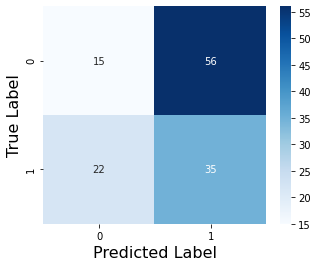

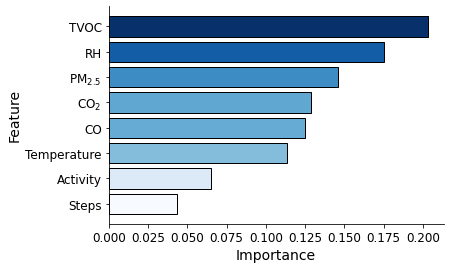

LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.554
		0.364
		0.603
		0.41
		0.435
	Average:	0.473
	Model Score: 0.517
Evaluating...


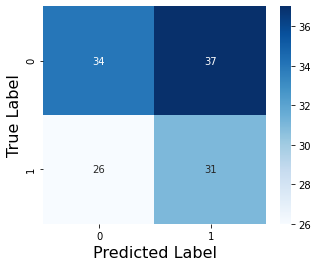

'LogisticRegression' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.479
		0.388
		0.531
		0.398
		0.528
	Average:	0.465
	Model Score: 0.403
Evaluating...


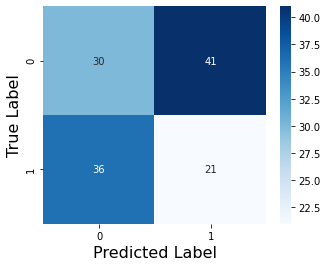

'BernoulliNB' object has no attribute 'feature_importances_'
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.423
		0.478
		0.435
		0.51
		0.533
	Average:	0.476
	Model Score: 0.46
Evaluating...


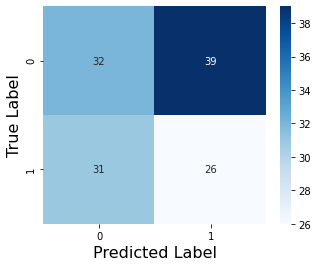

'KNeighborsClassifier' object has no attribute 'feature_importances_'
SPLIT 3
	Train:	382
	Test:	126

Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.127250
		Best Score:	0.5286397812713602
		Best Params:	{'fit_intercept': False, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:16.554336
		Best Score:	0.4790840738209159
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.064331
		Best Score:	0.46329460013670537
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.399287
		Best Score:	0.45044429254955576
		Best Params:	{'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Logistic Regression
		Score:	0.529
		Params:	{'fit_intercept': False, 'solver': 'lbfgs'}
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.582
		0.545
		0.579
		0.448
		0.5
	Average:	0.531
	Model Score: 0.46
Evaluating...


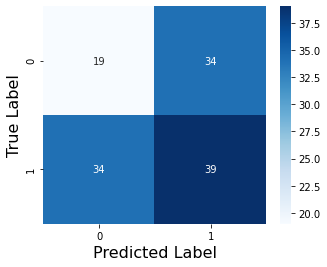

'LogisticRegression' object has no attribute 'feature_importances_'
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.547
		0.402
		0.566
		0.382
		0.5
	Average:	0.479
	Model Score: 0.517
Evaluating...


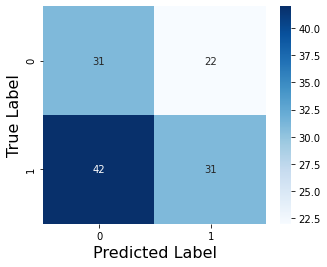

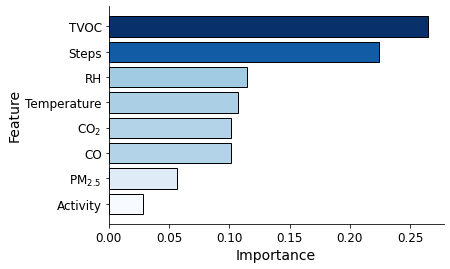

BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.536
		0.402
		0.525
		0.36
		0.473
	Average:	0.459
	Model Score: 0.448
Evaluating...


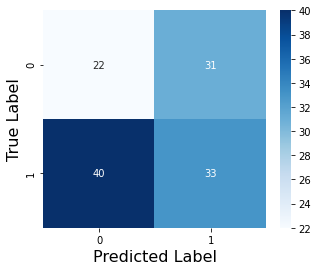

'BernoulliNB' object has no attribute 'feature_importances_'
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.49
		0.326
		0.51
		0.356
		0.558
	Average:	0.448
	Model Score: 0.524
Evaluating...


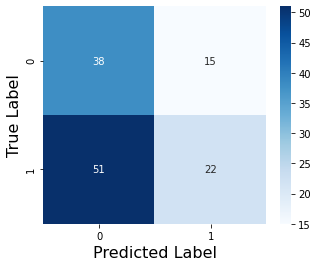

'KNeighborsClassifier' object has no attribute 'feature_importances_'
Getting Features and Target (deep_percent)...
SPLIT 4
	Train:	381
	Test:	127

Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.122516
		Best Score:	0.53526999316473
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:16.560045
		Best Score:	0.5826384142173615
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.063277
		Best Score:	0.4958988380041012
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.399971
		Best Score:	0.5377306903622693
		Best Params:	{'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.583
		Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.357
		0.366
		0.351


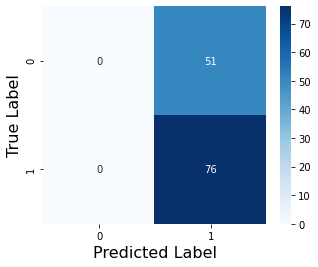

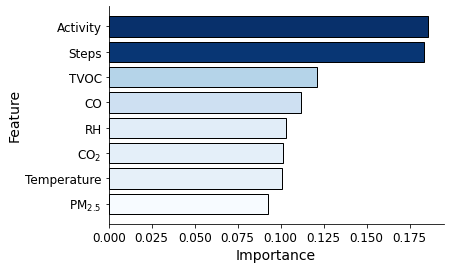

K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.654
		0.422
		0.429
		0.416
		0.67
	Average:	0.518
	Model Score: 0.522
Evaluating...


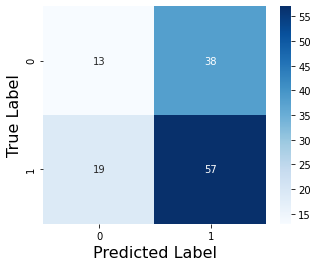

'KNeighborsClassifier' object has no attribute 'feature_importances_'
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.563
		0.428
		0.513
		0.451
		0.589
	Average:	0.509
	Model Score: 0.566
Evaluating...


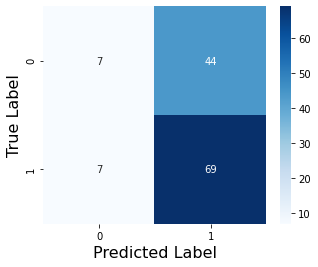

'LogisticRegression' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.54
		0.372
		0.506
		0.382
		0.547
	Average:	0.47
	Model Score: 0.607
Evaluating...


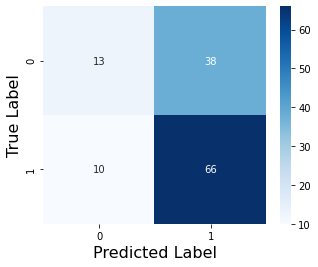

'BernoulliNB' object has no attribute 'feature_importances_'
SPLIT 4
	Train:	381
	Test:	127

Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.124295
		Best Score:	0.6298359535201641
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:16.501299
		Best Score:	0.6772043745727957
		Best Params:	{'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.064247
		Best Score:	0.648257006151743
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.399682
		Best Score:	0.6510252904989746
		Best Params:	{'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.677
		Params:	{'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.62
		0.53
		0.679
		0.799
		0.67
	Average:	0.66
	Model Score: 0.591
Evalua

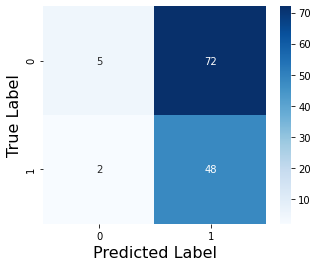

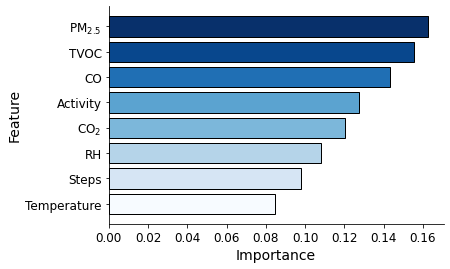

K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.588
		0.526
		0.594
		0.646
		0.713
	Average:	0.614
	Model Score: 0.543
Evaluating...


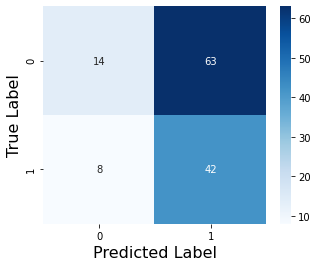

'KNeighborsClassifier' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.439
		0.438
		0.618
		0.43
		0.43
	Average:	0.471
	Model Score: 0.155
Evaluating...


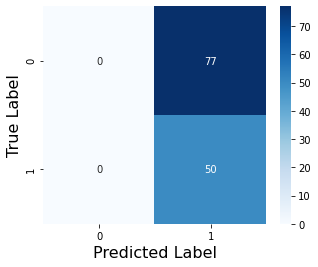

'BernoulliNB' object has no attribute 'feature_importances_'
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.439
		0.424
		0.541
		0.43
		0.43
	Average:	0.453
	Model Score: 0.155
Evaluating...


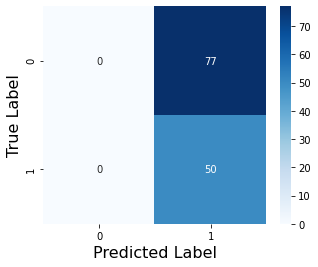

'LogisticRegression' object has no attribute 'feature_importances_'
SPLIT 4
	Train:	380
	Test:	128

Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.115637
		Best Score:	0.5605263157894737
		Best Params:	{'fit_intercept': False, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:16.560155
		Best Score:	0.5842105263157895
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.064618
		Best Score:	0.5368421052631579
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.405617
		Best Score:	0.5736842105263158
		Best Params:	{'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.584
		Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.567
		0.576
		0.463
		0.589
		0.701
	Average:	0.579
	Model Score:

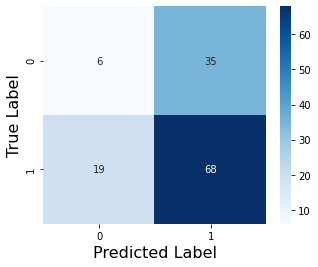

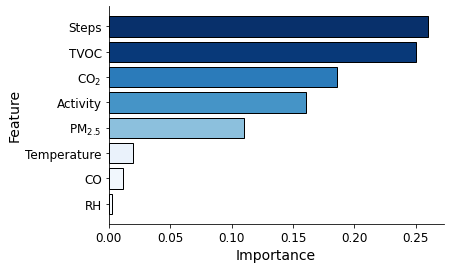

K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.536
		0.576
		0.551
		0.707
		0.553
	Average:	0.585
	Model Score: 0.572
Evaluating...


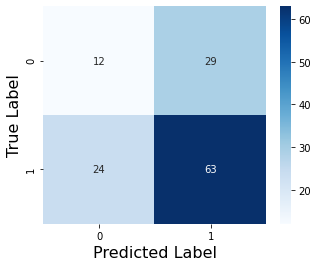

'KNeighborsClassifier' object has no attribute 'feature_importances_'
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.511
		0.513
		0.565
		0.583
		0.589
	Average:	0.552
	Model Score: 0.533
Evaluating...


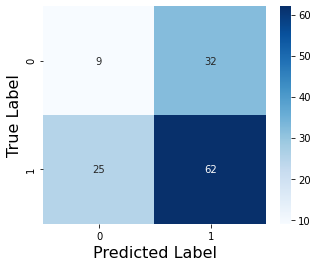

'LogisticRegression' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.494
		0.505
		0.479
		0.553
		0.584
	Average:	0.523
	Model Score: 0.551
Evaluating...


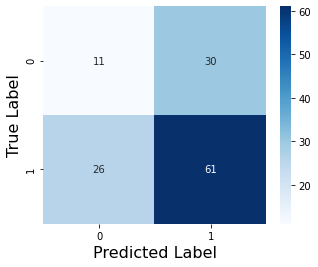

'BernoulliNB' object has no attribute 'feature_importances_'
SPLIT 4
	Train:	382
	Test:	126

Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.133829
		Best Score:	0.531578947368421
		Best Params:	{'fit_intercept': False, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:16.519525
		Best Score:	0.5445317840054682
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.064289
		Best Score:	0.5132262474367738
		Best Params:	{'alpha': 0.5}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.401871
		Best Score:	0.49494190020505807
		Best Params:	{'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.545
		Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.603
		0.455
		0.374
		0.64
		0.64
	Average:	0.542
	Model Score: 0.686


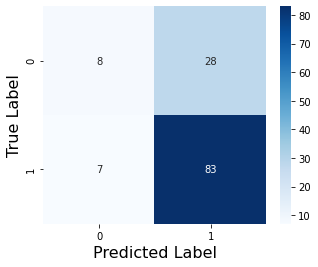

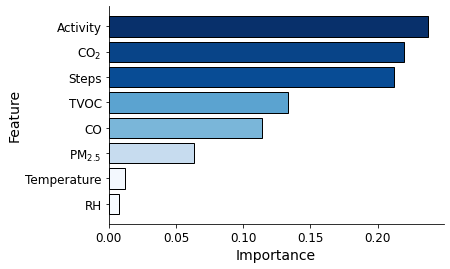

LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.521
		0.443
		0.395
		0.589
		0.656
	Average:	0.521
	Model Score: 0.581
Evaluating...


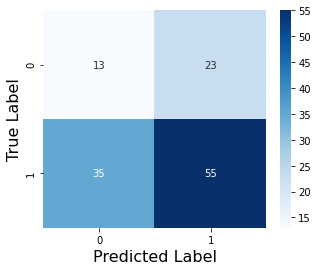

'LogisticRegression' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.573
		0.388
		0.401
		0.572
		0.601
	Average:	0.507
	Model Score: 0.592
Evaluating...


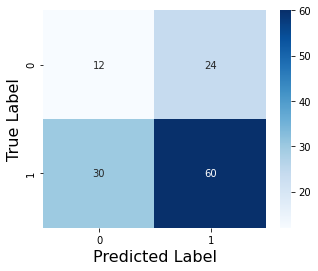

'BernoulliNB' object has no attribute 'feature_importances_'
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.577
		0.324
		0.552
		0.485
		0.488
	Average:	0.485
	Model Score: 0.668
Evaluating...


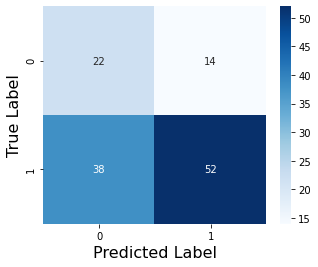

'KNeighborsClassifier' object has no attribute 'feature_importances_'
Getting Features and Target (rem_percent)...
SPLIT 5
	Train:	381
	Test:	127

Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.121035
		Best Score:	0.6219753930280246
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:16.480779
		Best Score:	0.6482911825017089
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.064139
		Best Score:	0.5957621326042378
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.403999
		Best Score:	0.6038277511961723
		Best Params:	{'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.648
		Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.422
		0.433
		0.41

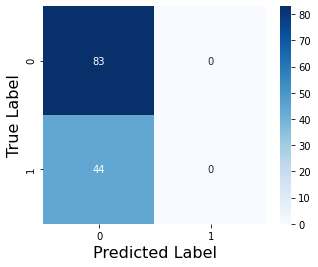

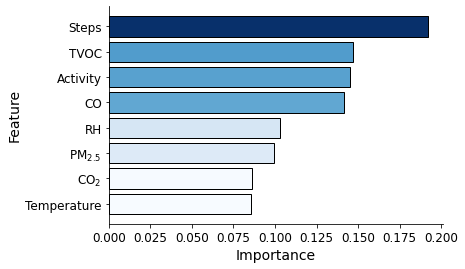

LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.422
		0.433
		0.452
		0.413
		0.413
	Average:	0.426
	Model Score: 0.422
Evaluating...


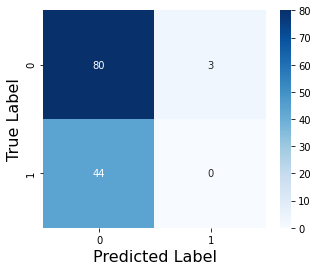

'LogisticRegression' object has no attribute 'feature_importances_'
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.525
		0.601
		0.528
		0.579
		0.653
	Average:	0.577
	Model Score: 0.573
Evaluating...


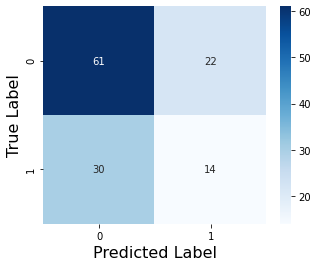

'KNeighborsClassifier' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.518
		0.495
		0.428
		0.416
		0.48
	Average:	0.467
	Model Score: 0.454
Evaluating...


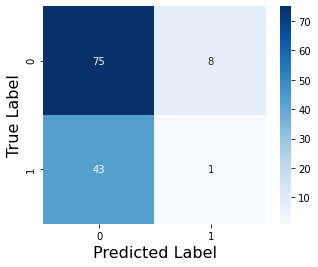

'BernoulliNB' object has no attribute 'feature_importances_'
SPLIT 5
	Train:	381
	Test:	127

Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.124912
		Best Score:	0.5904306220095694
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:16.543017
		Best Score:	0.6141831852358168
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.063829
		Best Score:	0.5694121667805878
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.399617
		Best Score:	0.5642173615857826
		Best Params:	{'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.614
		Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.373
		0.382
		0.382
		0.382
		0.366
	Average:	0.377
	Model Score: 0.571
E

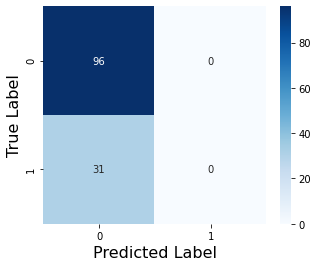

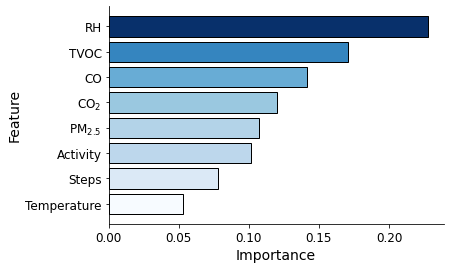

LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.772
		0.382
		0.382
		0.421
		0.357
	Average:	0.463
	Model Score: 0.571
Evaluating...


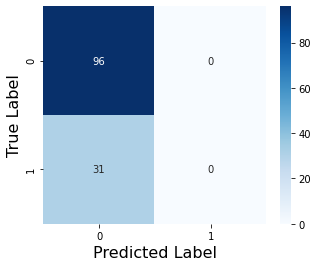

'LogisticRegression' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.767
		0.402
		0.382
		0.373
		0.366
	Average:	0.458
	Model Score: 0.571
Evaluating...


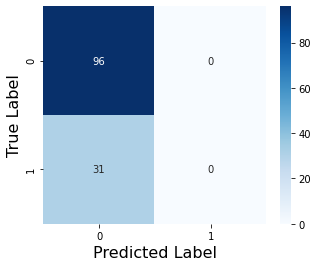

'BernoulliNB' object has no attribute 'feature_importances_'
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.605
		0.513
		0.628
		0.467
		0.521
	Average:	0.547
	Model Score: 0.66
Evaluating...


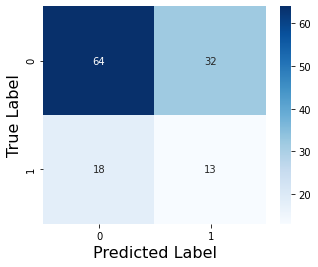

'KNeighborsClassifier' object has no attribute 'feature_importances_'
SPLIT 5
	Train:	380
	Test:	128

Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.122962
		Best Score:	0.6394736842105264
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:16.495699
		Best Score:	0.6605263157894737
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.064101
		Best Score:	0.631578947368421
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.395670
		Best Score:	0.6289473684210527
		Best Params:	{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.661
		Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.45
		0.433
		0.433
		0.433
		0.433
	Average:	0.436
	Model Score: 

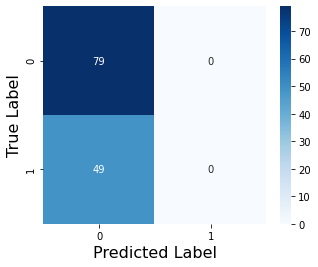

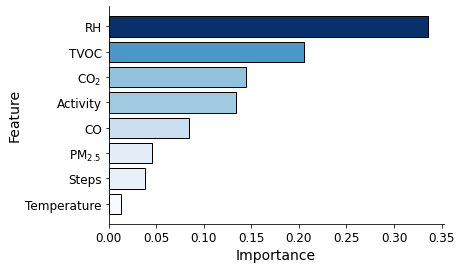

LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.618
		0.497
		0.433
		0.43
		0.433
	Average:	0.482
	Model Score: 0.535
Evaluating...


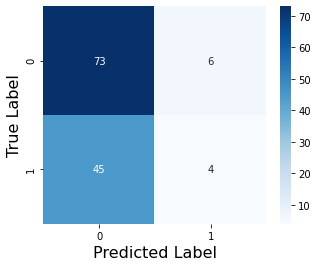

'LogisticRegression' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.785
		0.493
		0.433
		0.607
		0.424
	Average:	0.548
	Model Score: 0.612
Evaluating...


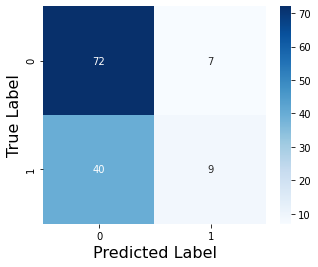

'BernoulliNB' object has no attribute 'feature_importances_'
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.606
		0.545
		0.608
		0.697
		0.605
	Average:	0.612
	Model Score: 0.601
Evaluating...


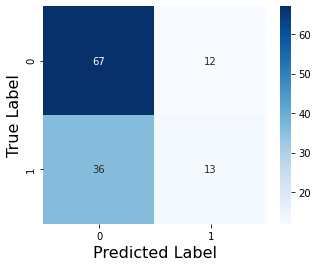

'KNeighborsClassifier' object has no attribute 'feature_importances_'
SPLIT 5
	Train:	382
	Test:	126

Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.119387
		Best Score:	0.6650034176349966
		Best Params:	{'fit_intercept': True, 'solver': 'liblinear'}
	Random Forest
		Elapsed Time:	 0:00:16.446991
		Best Score:	0.675393028024607
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.064167
		Best Score:	0.6468215994531784
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.399345
		Best Score:	0.6178742310321258
		Best Params:	{'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Random Forest
		Score:	0.675
		Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
RANDOM FOREST
Training...
Predicting...
	Cross Validation Scores:
		0.456
		0.456
		0.468
		0.45
		0.45
	Average:	0.456
	Model Scor

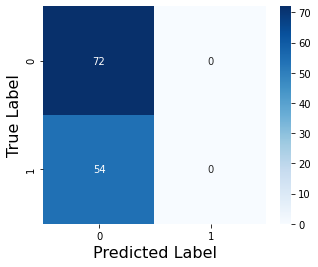

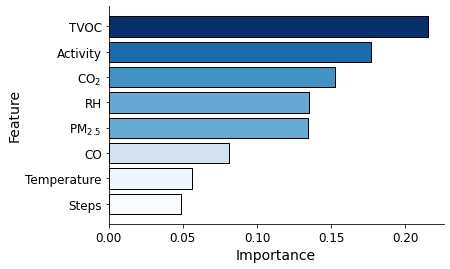

LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.444
		0.622
		0.79
		0.45
		0.447
	Average:	0.551
	Model Score: 0.327
Evaluating...


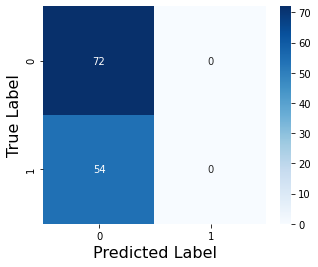

'LogisticRegression' object has no attribute 'feature_importances_'
BERNOULLI NAIVE BAYES
Training...
Predicting...
	Cross Validation Scores:
		0.501
		0.518
		0.79
		0.45
		0.447
	Average:	0.541
	Model Score: 0.541
Evaluating...


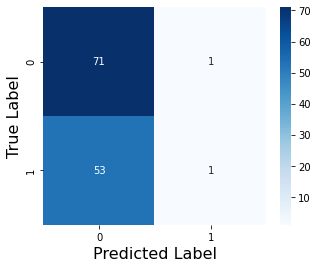

'BernoulliNB' object has no attribute 'feature_importances_'
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.515
		0.548
		0.596
		0.582
		0.62
	Average:	0.572
	Model Score: 0.623
Evaluating...


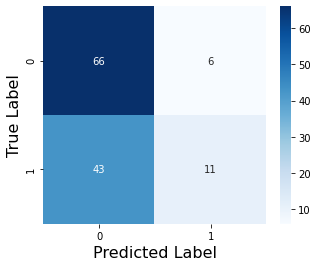

'KNeighborsClassifier' object has no attribute 'feature_importances_'


In [107]:
from sklearn.model_selection import GroupKFold, LeaveOneGroupOut

group_pred = ieq_and_sq_prediction()


gkf = GroupKFold(n_splits=4)#len(test.features["count"].unique()))
i = 1
res_group = {"split":[],"n_train":[],"n_test":[],"target":[],"best_performing_model":[],"model_score":[],"biased_score":[],"sensitive_parameter1":[],"sensitive_parameter2":[]}
for fb_target in ["se","tst","light_percent","deep_percent","rem_percent"]: 
    group_pred.get_features_and_targets(ieq_and_activity,fbsq,fb_target)
    for train, test in gkf.split(group_pred.features, group_pred.targets, groups=group_pred.features["count"]):
        print("SPLIT", i)
        print(f"\tTrain:\t{len(train)}\n\tTest:\t{len(test)}\n")
        group_pred.set_test_and_train(group_pred.features.iloc[train,:],group_pred.features.iloc[test,:],group_pred.targets.iloc[train,:],group_pred.targets.iloc[test,:])
        group_pred.optimize_models()
        # saves the best model, trains on the best model, predicts with the model, and plots the confusion matrix
        for model_number in range(len(group_pred.results)):
            print(group_pred.results.iloc[model_number,0].replace("_"," ").upper())
            group_pred.model = group_pred.classifier_model_params[group_pred.results.iloc[model_number,:]["model"]]["model"].set_params(**group_pred.results.iloc[model_number,:]["best_params"])
            group_pred.train_model(group_pred.model)
            group_pred.predict()
            group_pred.plot_confusion_matrix()
            group_pred.set_feature_importance(plot=True)

        res_group["split"].append(i)
        res_group["n_train"].append(len(train))
        res_group["n_test"].append(len(test))
        res_group["target"].append(fb_target)
        res_group["best_performing_model"].append(group_pred.results.iloc[0,0])
        res_group["model_score"].append(group_pred.results.iloc[0,1])
        bs = sum(group_pred.targets.values)/len(group_pred.targets)
        res_group["biased_score"].append(bs[0] if bs[0] > 0.5 else 1-bs[0])
        try:
            res_group["sensitive_parameter1"].append(group_pred.feature_importance.sort_values("importance",ascending=False).iloc[0,0])
            res_group["sensitive_parameter2"].append(group_pred.feature_importance.sort_values("importance",ascending=False).iloc[1,0])
        except KeyError:
            res_group["sensitive_parameter1"].append(np.nan)
            res_group["sensitive_parameter2"].append(np.nan)

        i += 1

In [108]:
pd.DataFrame(res_group)

,split,n_train,n_test,target,best_performing_model,model_score,biased_score,sensitive_parameter1,sensitive_parameter2
0,1,381,127,se,logistic_regression,0.813671,0.797244,rh,co
1,1,381,127,se,logistic_regression,0.797915,0.797244,steps,co
2,1,380,128,se,logistic_regression,0.818421,0.797244,rh,temperature
3,1,382,126,se,random_forest,0.759193,0.797244,steps,rh
4,2,381,127,tst,random_forest,0.611552,0.653543,active,steps
5,2,381,127,tst,random_forest,0.648291,0.653543,co2,temperature
6,2,380,128,tst,random_forest,0.657895,0.653543,temperature,steps
7,2,382,126,tst,random_forest,0.701572,0.653543,steps,pm2p5
8,3,381,127,light_percent,logistic_regression,0.482946,0.513780,tvoc,co
9,3,381,127,light_percent,random_forest,0.490738,0.513780,steps,tvoc
